1. Import Required Libraries
Start by importing the necessary libraries.

In [1]:
import os
import fireducks.pandas as pd
import kagglehub

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_calibration_metrics(base_path, datasets, models, metrics, output_dir):
    """
    Generate plots comparing ECE and Calibration Time for transformed and non-transformed data,
    including 95% confidence intervals as error bars.

    Parameters:
        base_path (str): Path to the Aggregate folder.
        datasets (list): List of datasets to process.
        models (list): List of models (e.g., cnn, GB, RF).
        metrics (list): Distance metrics (e.g., L1, L2).
        output_dir (str): Directory to save the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for dataset in datasets:
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Two subplots: ECE and Time
        fig.suptitle(f"Dataset: {dataset} - Calibration Comparison")

        bar_width = 0.2  # Width of each bar
        x_positions = {}  # Store X positions for metrics

        for i, transformed in enumerate([True, False]):
            ece_data, time_data = {}, {}

            for model in models:
                for metric in metrics:
                    filename = f"aggregate_results_{'transformed' if transformed else 'non_transformed'}_{metric}.csv"
                    file_path = os.path.join(base_path, dataset, model, filename)

                    if os.path.exists(file_path):
                        data = pd.read_csv(file_path)

                        # Extract data for each calibration method
                        for _, row in data.iterrows():
                            method = row["Metric"]
                            if method not in ece_data:
                                ece_data[method] = []
                                time_data[method] = []

                            # Append ECE mean and error bar (Upper CI - mean)
                            ece_mean = row["ECE mean"]
                            ece_error = row["ECE 95% CI Upper"] - ece_mean
                            ece_data[method].append((metric, ece_mean, ece_error))

                            # Append Calibration Time mean and error bar
                            time_mean = row["Calibration Time (s) mean"]
                            time_error = row["Calibration Time (s) 95% CI Upper"] - time_mean
                            time_data[method].append((metric, time_mean, time_error))

            # Prepare data for plotting
            calibration_methods = list(ece_data.keys())
            if not x_positions:
                x_positions = {method: i for i, method in enumerate(calibration_methods)}

            for metric_idx, metric in enumerate(metrics):
                x_offsets = [x_positions[method] + metric_idx * bar_width for method in calibration_methods]

                # Plot ECE with error bars
                ece_values = [next((v for m, v, _ in ece_data[method] if m == metric), 0) for method in calibration_methods]
                ece_errors = [next((e for m, _, e in ece_data[method] if m == metric), 0) for method in calibration_methods]
                axes[0].bar(x_offsets, ece_values, bar_width, yerr=ece_errors,
                            label=f"{metric} {'Transformed' if transformed else 'Non-Transformed'}",
                            alpha=0.7, capsize=5)

                # Plot Calibration Time with error bars
                time_values = [next((v for m, v, _ in time_data[method] if m == metric), 0) for method in calibration_methods]
                time_errors = [next((e for m, _, e in time_data[method] if m == metric), 0) for method in calibration_methods]
                axes[1].bar(x_offsets, time_values, bar_width, yerr=time_errors,
                            label=f"{metric} {'Transformed' if transformed else 'Non-Transformed'}",
                            alpha=0.7, capsize=5)

        # Set plot properties
        axes[0].set_title("ECE Comparison with 95% Confidence Interval")
        axes[0].set_ylabel("ECE Mean")
        axes[0].set_xticks([x_positions[method] + bar_width for method in calibration_methods])
        axes[0].set_xticklabels(calibration_methods, rotation=45)
        axes[0].legend()

        axes[1].set_title("Calibration Time Comparison with 95% Confidence Interval")
        axes[1].set_ylabel("Time (s)")
        axes[1].set_xticks([x_positions[method] + bar_width for method in calibration_methods])
        axes[1].set_xticklabels(calibration_methods, rotation=45)
        axes[1].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
        output_file = os.path.join(output_dir, f"{dataset}_calibration_comparison_with_CI.png")
        plt.savefig(output_file)
        plt.close()
        print(f"Saved plot for dataset: {dataset} to {output_file}")

# Example Usage
base_path = "/cs/cs_groups/cliron_group/Calibrato/Aggregate"
datasets = ["CIFAR10", "CIFAR100", "MNIST", "Fashion_MNIST", "GTSRB", "SignLanguage"]
models = ["cnn", "GB", "RF"]
metrics = ["cosine", "L1", "L2", "Linf"]
output_dir = "calibration_plots"

plot_calibration_metrics(base_path, datasets, models, metrics, output_dir)


Saved plot for dataset: CIFAR10 to calibration_plots/CIFAR10_calibration_comparison_with_CI.png
Saved plot for dataset: CIFAR100 to calibration_plots/CIFAR100_calibration_comparison_with_CI.png
Saved plot for dataset: MNIST to calibration_plots/MNIST_calibration_comparison_with_CI.png
Saved plot for dataset: Fashion_MNIST to calibration_plots/Fashion_MNIST_calibration_comparison_with_CI.png
Saved plot for dataset: GTSRB to calibration_plots/GTSRB_calibration_comparison_with_CI.png
Saved plot for dataset: SignLanguage to calibration_plots/SignLanguage_calibration_comparison_with_CI.png


2. Define Paths
Set up the base path where your data is stored and the output paths for combined and aggregated results.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_knn_comparison(base_path, datasets, models, metrics, output_dir):
    """
    Compare the KNN method across all datasets and models for ECE (with 95% CI) and Calibration Time.

    Parameters:
        base_path (str): Path to the Aggregate folder.
        datasets (list): List of datasets to process.
        models (list): List of models (e.g., cnn, GB, RF).
        metrics (list): Distance metrics (e.g., L1, L2).
        output_dir (str): Directory to save the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    ece_data = {"Dataset": [], "Model": [], "Transformed": [], "ECE Mean": [], "ECE Error": []}
    time_data = {"Dataset": [], "Model": [], "Transformed": [], "Time Mean": [], "Time Error": []}

    # Collect data
    for dataset in datasets:
        for model in models:
            for transformed in [True, False]:
                for metric in metrics:
                    filename = f"aggregate_results_{'transformed' if transformed else 'non_transformed'}_{metric}.csv"
                    file_path = os.path.join(base_path, dataset, model, filename)

                    if os.path.exists(file_path):
                        data = pd.read_csv(file_path)

                        # Filter for KNN method only
                        data["Metric"] = data["Metric"].str.lower().str.strip()
                        knn_row = data[data["Metric"] == "knn"]

                        if not knn_row.empty:
                            row = knn_row.iloc[0]

                            # Collect ECE data
                            ece_data["Dataset"].append(dataset)
                            ece_data["Model"].append(model)
                            ece_data["Transformed"].append("Transformed" if transformed else "Non-Transformed")
                            ece_data["ECE Mean"].append(row["ECE mean"])
                            ece_data["ECE Error"].append(row["ECE 95% CI Upper"] - row["ECE mean"])

                            # Collect Calibration Time
                            time_data["Dataset"].append(dataset)
                            time_data["Model"].append(model)
                            time_data["Transformed"].append("Transformed" if transformed else "Non-Transformed")
                            time_data["Time Mean"].append(row["Calibration Time (s) mean"])
                            time_data["Time Error"].append(row["Calibration Time (s) 95% CI Upper"] - row["Calibration Time (s) mean"])

    # Convert to DataFrames
    ece_df = pd.DataFrame(ece_data)
    time_df = pd.DataFrame(time_data)

    # Plot configuration
    datasets_unique = datasets
    models_unique = models
    x = np.arange(len(datasets_unique))  # Position for each dataset
    width = 0.2  # Bar width for each model

    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    fig.suptitle("KNN Method Comparison Across Datasets and Models")

    # Plot ECE Comparison
    for idx, model in enumerate(models_unique):
        model_ece = ece_df[ece_df["Model"] == model]
        for transformed in ["Transformed", "Non-Transformed"]:
            subset = model_ece[model_ece["Transformed"] == transformed]

            # Calculate bar positions for this model and transformed group
            bar_positions = x + idx * width + (0 if transformed == "Transformed" else width / 2)

            ece_values = [subset[subset["Dataset"] == dataset]["ECE Mean"].values[0]
                          if not subset[subset["Dataset"] == dataset].empty else 0
                          for dataset in datasets_unique]
            ece_errors = [subset[subset["Dataset"] == dataset]["ECE Error"].values[0]
                          if not subset[subset["Dataset"] == dataset].empty else 0
                          for dataset in datasets_unique]

            axes[0].bar(bar_positions, ece_values, width / 2,
                        yerr=ece_errors, capsize=5,
                        label=f"{model} ({transformed})")

    axes[0].set_title("ECE Comparison with 95% Confidence Interval")
    axes[0].set_ylabel("ECE Mean")
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels(datasets_unique)
    axes[0].legend()

    # Plot Calibration Time Comparison
    for idx, model in enumerate(models_unique):
        model_time = time_df[time_df["Model"] == model]
        for transformed in ["Transformed", "Non-Transformed"]:
            subset = model_time[model_time["Transformed"] == transformed]

            # Calculate bar positions for this model and transformed group
            bar_positions = x + idx * width + (0 if transformed == "Transformed" else width / 2)

            time_values = [subset[subset["Dataset"] == dataset]["Time Mean"].values[0]
                           if not subset[subset["Dataset"] == dataset].empty else 0
                           for dataset in datasets_unique]
            time_errors = [subset[subset["Dataset"] == dataset]["Time Error"].values[0]
                           if not subset[subset["Dataset"] == dataset].empty else 0
                           for dataset in datasets_unique]

            axes[1].bar(bar_positions, time_values, width / 2,
                        yerr=time_errors, capsize=5,
                        label=f"{model} ({transformed})")

    axes[1].set_title("Calibration Time Comparison with 95% Confidence Interval")
    axes[1].set_ylabel("Time (s)")
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels(datasets_unique)
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    output_file = os.path.join(output_dir, "KNN_comparison_across_datasets_models.png")
    plt.savefig(output_file)
    plt.close()
    print(f"Saved KNN comparison plot to {output_file}")

# Example Usage
base_path = "/cs/cs_groups/cliron_group/Calibrato/Aggregate"
datasets = ["CIFAR10", "CIFAR100", "MNIST", "Fashion_MNIST", "GTSRB", "SignLanguage"]
models = ["cnn", "GB", "RF", "pretrained_efficientnet"]
metrics = ["cosine", "L1", "L2", "Linf"]
output_dir = "knn_comparison_plots"

plot_knn_comparison(base_path, datasets, models, metrics, output_dir)

Saved KNN comparison plot to knn_comparison_plots/KNN_comparison_across_datasets_models.png


In [2]:
# Paths
base_path = "/cs/cs_groups/cliron_group/Calibrato/"
datasets = ["MNIST", "CIFAR10", "Fashion_MNIST", "SignLanguage", "CIFAR100", "GTRSB"]  # Add other datasets if needed
models = ["GB", "RF", "cnn"]  # Models to include
distance_metrics = ["L1", "L2", "Linf", "cosine"]  # Distance metrics
combined_files = {
    "transformed": "/cs/cs_groups/cliron_group/Calibrato/Combined/combined_results_transformed_{dataset}_{model}_{metric}.csv",
    "non_transformed": "/cs/cs_groups/cliron_group/Calibrato/Combined/combined_results_non_transformed_{dataset}_{model}_{metric}.csv"
}
aggregate_files = {
    "transformed": "/cs/cs_groups/cliron_group/Calibrato/Aggregate/{dataset}/{model}/aggregate_results_transformed_{metric}.csv",
    "non_transformed": "/cs/cs_groups/cliron_group/Calibrato/Aggregate/{dataset}/{model}/aggregate_results_non_transformed_{metric}.csv"
}

3. Combine Results
Create a cell to iterate through your folders, extract metadata, and combine all CSV files.

In [3]:
def combine_results(base_path, dataset_filter, model_filter, metric_filter, transformed_filter):
    """
    Combines results from multiple CSV files into a single DataFrame.

    Parameters:
        base_path (str): The base path to search for files.
        dataset_filter (str): Dataset to filter (e.g., 'MNIST', 'CIFAR100').
        model_filter (str): Model to filter (e.g., 'GB', 'RF', 'cnn').
        metric_filter (str): Distance metric to filter (e.g., 'L1', 'L2').
        transformed_filter (bool): Whether to filter for transformed paths.

    Returns:
        pd.DataFrame: Combined DataFrame of results.
    """
    combined_data = []

    for root, _, files in os.walk(base_path):
        # Filter directories based on dataset, model, and metric
        if dataset_filter not in root or model_filter not in root or metric_filter not in root:
            continue

        # Check for transformed or non-transformed filter
        is_transformed = "transformed" in root
        if is_transformed != transformed_filter:
            continue

        for file in files:
            if file.endswith("all_results.csv"):
                # Extract metadata
                path_parts = root.split('/')
                try:
                    random_state = path_parts[-5 if is_transformed else -4]
                except IndexError:
                    print(f"Unexpected path structure: {root}. Skipping.")
                    continue

                # Attempt to read the CSV file
                file_path = os.path.join(root, file)
                try:
                    data = pd.read_csv(file_path)
                    if data.empty:
                        print(f"Empty data in file: {file_path}. Skipping.")
                        continue
                except pd.errors.EmptyDataError:
                    print(f"File is empty or unreadable: {file_path}. Skipping.")
                    continue
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}. Skipping.")
                    continue

                # Add metadata columns
                data['Dataset'] = dataset_filter
                data['Random State'] = int(random_state)
                data['Model'] = model_filter
                data['Distance Metric'] = metric_filter
                data['Transformed'] = is_transformed

                combined_data.append(data)

    # Combine all collected data
    if combined_data:
        return pd.concat(combined_data, ignore_index=True)
    else:
        print(f"No valid data found for dataset: {dataset_filter}, model: {model_filter}, metric: {metric_filter}, transformed: {transformed_filter}")
        return pd.DataFrame()
    
# Ensure the combined_data folder exists
output_dir = os.path.join(base_path, "combined_data")
os.makedirs(output_dir, exist_ok=True)

# Process for each dataset, model, and metric
for dataset in datasets:
    for model in models:
        for metric in distance_metrics:
            # Transformed results
            combined_df_transformed = combine_results(base_path, dataset, model, metric, transformed_filter=True)
            if not combined_df_transformed.empty:
                transformed_file = combined_files["transformed"].format(dataset=dataset, model=model, metric=metric)
                combined_df_transformed.to_csv(transformed_file, index=False)
                print(f"Transformed results for {dataset}, {model}, {metric} saved to {transformed_file}")
            else:
                print(f"No transformed data for {dataset}, {model}, {metric}.")

            # Non-transformed results
            combined_df_non_transformed = combine_results(base_path, dataset, model, metric, transformed_filter=False)
            if not combined_df_non_transformed.empty:
                non_transformed_file = combined_files["non_transformed"].format(dataset=dataset, model=model, metric=metric)
                combined_df_non_transformed.to_csv(non_transformed_file, index=False)
                print(f"Non-transformed results for {dataset}, {model}, {metric} saved to {non_transformed_file}")
            else:
                print(f"No non-transformed data for {dataset}, {model}, {metric}.")


KeyboardInterrupt: 

Step 4 - Aggregate Results
Now that we have combined the results for all datasets, the next step is to aggregate the data. We will group by calibration methods (e.g., Metric) and calculate statistical summaries (e.g., mean, standard deviation) for each dataset. This allows us to compare the performance of different calibration techniques across datasets.

In [4]:
import scipy.stats as stats

# Function to aggregate results
def aggregate_results(file_path, group_by_columns, aggregate_columns):
    """
    Aggregates results by calculating mean, standard deviation, count, and 95% confidence intervals.

    Parameters:
        file_path (str): Path to the combined CSV file.
        group_by_columns (list): Columns to group by (e.g., ['Metric', 'Dataset', 'Distance Metric']).
        aggregate_columns (list): Columns to aggregate (e.g., ['ECE', 'MCE', 'Brier Score']).

    Returns:
        pd.DataFrame: Aggregated DataFrame with mean, standard deviation, count, and confidence intervals.
    """
    # Load data
    data = pd.read_csv(file_path)
    
    # Ensure Distance Metric is part of grouping columns
    if 'Distance Metric' not in group_by_columns:
        group_by_columns.append('Distance Metric')
    
    # Aggregate results
    aggregated = (
        data.groupby(group_by_columns)[aggregate_columns]
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    
    # Flatten the multi-level columns
    aggregated.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in aggregated.columns]

    # Calculate 95% confidence intervals
    for col in aggregate_columns:
        mean_col = f"{col} mean"
        std_col = f"{col} std"
        count_col = f"{col} count"
        ci_lower_col = f"{col} 95% CI Lower"
        ci_upper_col = f"{col} 95% CI Upper"

        # Add confidence interval columns
        aggregated[ci_lower_col] = aggregated[mean_col] - stats.t.ppf(0.975, aggregated[count_col] - 1) * (aggregated[std_col] / (aggregated[count_col] ** 0.5))
        aggregated[ci_upper_col] = aggregated[mean_col] + stats.t.ppf(0.975, aggregated[count_col] - 1) * (aggregated[std_col] / (aggregated[count_col] ** 0.5))

    return aggregated

# Define columns to group by and aggregate
group_by_columns = ['Metric', 'Dataset', 'Distance Metric', 'Model', 'Transformed']
aggregate_columns = ['ECE', 'MCE', 'Brier Score', 'Log Loss', 'Calibration Time (s)']

# Aggregate results for each dataset, model, and metric
output_dir = "aggregated_results"  # Directory to save the aggregated tables
os.makedirs(output_dir, exist_ok=True)

for dataset in datasets:
    for model in models:
        for metric in distance_metrics:
            # Transformed results
            transformed_file = combined_files["transformed"].format(dataset=dataset, model=model, metric=metric)
            if os.path.exists(transformed_file):
                aggregated_transformed = aggregate_results(transformed_file, group_by_columns, aggregate_columns)
                output_file = os.path.join(output_dir, f"{dataset}_{model}_{metric}_transformed.csv")
                aggregated_transformed.to_csv(output_file, index=False)
                print(f"Aggregated Transformed Results saved to {output_file}")
                display(aggregated_transformed)  # Display in notebook

            # Non-transformed results
            non_transformed_file = combined_files["non_transformed"].format(dataset=dataset, model=model, metric=metric)
            if os.path.exists(non_transformed_file):
                aggregated_non_transformed = aggregate_results(non_transformed_file, group_by_columns, aggregate_columns)
                output_file = os.path.join(output_dir, f"{dataset}_{model}_{metric}_non_transformed.csv")
                aggregated_non_transformed.to_csv(output_file, index=False)
                print(f"Aggregated Non-Transformed Results saved to {output_file}")
                display(aggregated_non_transformed)  # Display in notebook


Aggregated Transformed Results saved to aggregated_results/MNIST_GB_L1_transformed.csv


,Metric,Dataset,Distance Metric,Model,Transformed,ECE mean,ECE std,ECE count,MCE mean,MCE std,...,ECE 95% CI Lower,ECE 95% CI Upper,MCE 95% CI Lower,MCE 95% CI Upper,Brier Score 95% CI Lower,Brier Score 95% CI Upper,Log Loss 95% CI Lower,Log Loss 95% CI Upper,Calibration Time (s) 95% CI Lower,Calibration Time (s) 95% CI Upper
0,Faiss exact,MNIST,L1,GB,True,0.503773,0.029946,22,0.576687,0.156032,...,0.490496,0.517051,0.507507,0.645868,0.102644,0.110153,2.873906,2.929952,424.713490,603.334087
1,Isotonic,MNIST,L1,GB,True,0.285483,0.046907,22,0.522072,0.059144,...,0.264685,0.306280,0.495849,0.548295,0.077807,0.086573,2.381163,3.141093,0.109324,0.127929
2,Knn,MNIST,L1,GB,True,0.159699,0.033799,22,0.522367,0.121243,...,0.144713,0.174684,0.468611,0.576123,0.063582,0.071779,1.683509,1.879475,675.336270,751.046098
3,Platt,MNIST,L1,GB,True,0.363828,0.019711,22,0.588896,0.092355,...,0.355089,0.372568,0.547948,0.629844,0.088045,0.092832,2.380607,2.990579,0.145419,0.176845
4,Temperature,MNIST,L1,GB,True,0.518665,0.067562,22,0.724511,0.017277,...,0.488710,0.548621,0.716850,0.732171,0.104057,0.115814,12.327496,13.090849,0.518542,0.703181
5,Trust Score Filtered,MNIST,L1,GB,True,0.297578,0.023189,22,0.427924,0.004657,...,0.287296,0.307859,0.425859,0.429988,0.076124,0.082955,19.990664,22.283030,887.746301,1085.868544
6,Trust Score Unfiltered,MNIST,L1,GB,True,0.303605,0.026787,22,0.430600,0.003415,...,0.291728,0.315482,0.429086,0.432114,0.076195,0.083125,19.991540,22.284466,748.931600,903.100438
7,Uncalibrated,MNIST,L1,GB,True,0.342596,0.040500,22,0.539712,0.030365,...,0.324639,0.360553,0.526249,0.553175,0.082376,0.091339,2.769024,3.025506,NaN,NaN


Aggregated Non-Transformed Results saved to aggregated_results/MNIST_GB_L1_non_transformed.csv


,Metric,Dataset,Distance Metric,Model,Transformed,ECE mean,ECE std,ECE count,MCE mean,MCE std,...,ECE 95% CI Lower,ECE 95% CI Upper,MCE 95% CI Lower,MCE 95% CI Upper,Brier Score 95% CI Lower,Brier Score 95% CI Upper,Log Loss 95% CI Lower,Log Loss 95% CI Upper,Calibration Time (s) 95% CI Lower,Calibration Time (s) 95% CI Upper
0,Faiss exact,MNIST,L1,GB,False,0.002716,0.002537,144,0.136586,0.203292,...,0.002298,0.003134,0.103099,0.170073,0.009584,0.011918,0.299232,0.360106,512.329991,584.447724
1,Isotonic,MNIST,L1,GB,False,0.005818,0.002209,144,0.289170,0.162168,...,0.005454,0.006182,0.262457,0.315883,0.007356,0.009112,0.158861,0.190101,0.106722,0.114308
2,Knn,MNIST,L1,GB,False,0.005412,0.002811,144,0.400333,0.193851,...,0.004949,0.005875,0.368401,0.432265,0.007924,0.010047,0.221903,0.277718,711.131133,753.581769
3,Platt,MNIST,L1,GB,False,0.060866,0.028618,144,0.417819,0.188249,...,0.056152,0.065580,0.386810,0.448828,0.008471,0.010416,0.256762,0.296710,0.155699,0.170917
4,Temperature,MNIST,L1,GB,False,0.047570,0.034041,144,0.543418,0.078403,...,0.041962,0.053177,0.530503,0.556332,0.009329,0.011611,0.702719,0.791430,0.595334,0.671537
5,Trust Score Filtered,MNIST,L1,GB,False,0.353370,0.029862,90,0.435048,0.063624,...,0.347115,0.359624,0.421723,0.448374,0.024415,0.026659,2.763756,3.397367,898.673839,974.357839
6,Trust Score Unfiltered,MNIST,L1,GB,False,0.357513,0.029858,90,0.419341,0.007048,...,0.351259,0.363766,0.417864,0.420817,0.024499,0.026772,2.765860,3.400081,739.687172,802.866538
7,Uncalibrated,MNIST,L1,GB,False,0.019141,0.003919,144,0.346773,0.180607,...,0.018495,0.019787,0.317023,0.376524,0.007549,0.009294,0.170118,0.199998,NaN,NaN


Aggregated Transformed Results saved to aggregated_results/MNIST_GB_L2_transformed.csv


,Metric,Dataset,Distance Metric,Model,Transformed,ECE mean,ECE std,ECE count,MCE mean,MCE std,...,ECE 95% CI Lower,ECE 95% CI Upper,MCE 95% CI Lower,MCE 95% CI Upper,Brier Score 95% CI Lower,Brier Score 95% CI Upper,Log Loss 95% CI Lower,Log Loss 95% CI Upper,Calibration Time (s) 95% CI Lower,Calibration Time (s) 95% CI Upper
0,Faiss exact,MNIST,L2,GB,True,0.504255,0.027578,22,0.616686,0.190650,...,0.492028,0.516482,0.532157,0.701216,0.102954,0.110117,2.887744,2.936310,365.775474,518.071980
1,Isotonic,MNIST,L2,GB,True,0.286459,0.045073,22,0.537839,0.076482,...,0.266475,0.306444,0.503929,0.571749,0.078096,0.086660,2.391448,3.140087,0.105887,0.123066
2,Knn,MNIST,L2,GB,True,0.171294,0.042033,22,0.499874,0.139433,...,0.152658,0.189931,0.438053,0.561694,0.064021,0.073059,1.637900,1.847860,610.269471,731.226987
3,Platt,MNIST,L2,GB,True,0.364522,0.017879,22,0.565893,0.056710,...,0.356594,0.372449,0.540749,0.591036,0.088427,0.092878,2.388129,2.992466,0.139856,0.169548
4,Temperature,MNIST,L2,GB,True,0.518764,0.066492,22,0.718130,0.025060,...,0.489283,0.548244,0.707019,0.729241,0.104360,0.115829,12.384607,13.122689,0.476891,0.667886
5,Trust Score Filtered,MNIST,L2,GB,True,0.296921,0.022562,22,0.428197,0.004468,...,0.286918,0.306925,0.426216,0.430178,0.076288,0.082953,20.044933,22.282652,936.992503,1132.548952
6,Trust Score Unfiltered,MNIST,L2,GB,True,0.303274,0.026188,22,0.430754,0.003294,...,0.291663,0.314885,0.429293,0.432214,0.076357,0.083122,20.045818,22.284089,799.633544,970.909804
7,Uncalibrated,MNIST,L2,GB,True,0.343075,0.039139,22,0.562490,0.083740,...,0.325721,0.360428,0.525361,0.599618,0.082657,0.091441,2.777276,3.032817,NaN,NaN


Aggregated Non-Transformed Results saved to aggregated_results/MNIST_GB_L2_non_transformed.csv


,Metric,Dataset,Distance Metric,Model,Transformed,ECE mean,ECE std,ECE count,MCE mean,MCE std,...,ECE 95% CI Lower,ECE 95% CI Upper,MCE 95% CI Lower,MCE 95% CI Upper,Brier Score 95% CI Lower,Brier Score 95% CI Upper,Log Loss 95% CI Lower,Log Loss 95% CI Upper,Calibration Time (s) 95% CI Lower,Calibration Time (s) 95% CI Upper
0,Faiss exact,MNIST,L2,GB,False,0.002751,0.002666,144,0.116879,0.171081,...,0.002312,0.003190,0.088697,0.145060,0.009584,0.011918,0.299545,0.360634,361.325344,406.941905
1,Isotonic,MNIST,L2,GB,False,0.005818,0.002209,144,0.289170,0.162168,...,0.005454,0.006182,0.262457,0.315883,0.007356,0.009112,0.158861,0.190101,0.100974,0.108481
2,Knn,MNIST,L2,GB,False,0.005172,0.002607,144,0.403032,0.206608,...,0.004742,0.005601,0.368999,0.437066,0.007795,0.009963,0.216557,0.273782,603.055053,652.506138
3,Platt,MNIST,L2,GB,False,0.060866,0.028618,144,0.417819,0.188249,...,0.056152,0.065580,0.386810,0.448828,0.008471,0.010416,0.256762,0.296710,0.149456,0.162283
4,Temperature,MNIST,L2,GB,False,0.047570,0.034041,144,0.543418,0.078403,...,0.041962,0.053177,0.530503,0.556332,0.009329,0.011611,0.702719,0.791430,0.516683,0.590895
5,Trust Score Filtered,MNIST,L2,GB,False,0.353370,0.029862,90,0.435048,0.063624,...,0.347115,0.359624,0.421723,0.448374,0.024415,0.026659,2.763756,3.397367,917.641243,996.642055
6,Trust Score Unfiltered,MNIST,L2,GB,False,0.357513,0.029858,90,0.419341,0.007048,...,0.351259,0.363766,0.417864,0.420817,0.024499,0.026772,2.765860,3.400081,755.277437,821.220381
7,Uncalibrated,MNIST,L2,GB,False,0.019141,0.003919,144,0.346773,0.180607,...,0.018495,0.019787,0.317023,0.376524,0.007549,0.009294,0.170118,0.199998,NaN,NaN


Aggregated Transformed Results saved to aggregated_results/MNIST_GB_Linf_transformed.csv


,Metric,Dataset,Distance Metric,Model,Transformed,ECE mean,ECE std,ECE count,MCE mean,MCE std,...,ECE 95% CI Lower,ECE 95% CI Upper,MCE 95% CI Lower,MCE 95% CI Upper,Brier Score 95% CI Lower,Brier Score 95% CI Upper,Log Loss 95% CI Lower,Log Loss 95% CI Upper,Calibration Time (s) 95% CI Lower,Calibration Time (s) 95% CI Upper
0,Faiss exact,MNIST,Linf,GB,True,0.503162,0.030356,22,0.598978,0.185842,...,0.489703,0.516621,0.516580,0.681376,0.102770,0.110173,2.896053,2.998489,399.980012,579.834265
1,Isotonic,MNIST,Linf,GB,True,0.285929,0.046085,22,0.567930,0.107834,...,0.265497,0.306362,0.520120,0.615741,0.077864,0.086568,2.392332,3.141639,0.098749,0.120986
2,Knn,MNIST,Linf,GB,True,0.344372,0.064422,22,0.554658,0.041071,...,0.315809,0.372935,0.536449,0.572868,0.079769,0.091527,2.068279,2.292783,681.906460,781.796462
3,Platt,MNIST,Linf,GB,True,0.364263,0.019049,22,0.563993,0.057422,...,0.355817,0.372709,0.538533,0.589452,0.088134,0.092831,2.378020,2.992338,0.128961,0.175273
4,Temperature,MNIST,Linf,GB,True,0.518325,0.068059,22,0.712688,0.019107,...,0.488149,0.548500,0.704217,0.721160,0.104130,0.115814,12.340807,13.101831,0.481617,0.649418
5,Trust Score Filtered,MNIST,Linf,GB,True,0.297295,0.023048,22,0.428218,0.005137,...,0.287076,0.307514,0.425940,0.430496,0.076148,0.082955,19.996461,22.282905,894.904060,1107.677689
6,Trust Score Unfiltered,MNIST,Linf,GB,True,0.303192,0.026670,22,0.430876,0.003893,...,0.291367,0.315017,0.429150,0.432603,0.076218,0.083124,19.997329,22.284353,744.269156,930.056821
7,Uncalibrated,MNIST,Linf,GB,True,0.342655,0.040051,22,0.545381,0.069165,...,0.324897,0.360413,0.514715,0.576047,0.082429,0.091334,2.770682,3.032529,NaN,NaN


Aggregated Non-Transformed Results saved to aggregated_results/MNIST_GB_Linf_non_transformed.csv


,Metric,Dataset,Distance Metric,Model,Transformed,ECE mean,ECE std,ECE count,MCE mean,MCE std,...,ECE 95% CI Lower,ECE 95% CI Upper,MCE 95% CI Lower,MCE 95% CI Upper,Brier Score 95% CI Lower,Brier Score 95% CI Upper,Log Loss 95% CI Lower,Log Loss 95% CI Upper,Calibration Time (s) 95% CI Lower,Calibration Time (s) 95% CI Upper
0,Faiss exact,MNIST,Linf,GB,False,0.002549,0.002381,144,0.091788,0.204737,...,0.002156,0.002941,0.058062,0.125513,0.009582,0.011916,0.299441,0.360316,661.570871,1053.455453
1,Isotonic,MNIST,Linf,GB,False,0.005818,0.002209,144,0.289170,0.162168,...,0.005454,0.006182,0.262457,0.315883,0.007356,0.009112,0.158861,0.190101,0.105726,0.113335
2,Knn,MNIST,Linf,GB,False,0.008973,0.009339,144,0.376689,0.235855,...,0.007435,0.010512,0.337838,0.415540,0.009191,0.011499,0.268688,0.329737,760.856115,811.091045
3,Platt,MNIST,Linf,GB,False,0.060866,0.028618,144,0.417819,0.188249,...,0.056152,0.065580,0.386810,0.448828,0.008471,0.010416,0.256762,0.296710,0.152908,0.167913
4,Temperature,MNIST,Linf,GB,False,0.047570,0.034041,144,0.543418,0.078403,...,0.041962,0.053177,0.530503,0.556332,0.009329,0.011611,0.702719,0.791430,0.596808,0.681098
5,Trust Score Filtered,MNIST,Linf,GB,False,0.353370,0.029862,90,0.435048,0.063624,...,0.347115,0.359624,0.421723,0.448374,0.024415,0.026659,2.763756,3.397367,913.146460,990.860303
6,Trust Score Unfiltered,MNIST,Linf,GB,False,0.357513,0.029858,90,0.419341,0.007048,...,0.351259,0.363766,0.417864,0.420817,0.024499,0.026772,2.765860,3.400081,745.452573,807.612422
7,Uncalibrated,MNIST,Linf,GB,False,0.019141,0.003919,144,0.346773,0.180607,...,0.018495,0.019787,0.317023,0.376524,0.007549,0.009294,0.170118,0.199998,NaN,NaN


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

def process_and_aggregate_results(base_path, datasets, models, distance_metrics):
    """
    Combines results from multiple CSV files, aggregates them, and saves both combined and aggregated results.

    Parameters:
        base_path (str): The base path to search for files.
        datasets (list): List of datasets to process (e.g., ['MNIST', 'CIFAR100']).
        models (list): List of models to process (e.g., ['GB', 'RF', 'cnn']).
        distance_metrics (list): List of distance metrics (e.g., ['L1', 'L2']).
    """
    # Iterate over datasets, models, and distance metrics
    for dataset in tqdm(datasets, desc="Processing Datasets"):
        for model in tqdm(models, desc=f"Processing Models for {dataset}", leave=False):
            for metric in tqdm(distance_metrics, desc=f"Processing Metrics for {model}", leave=False):
                # Define file paths dynamically for each combination
                aggregate_files = {
                    "transformed": f"/cs/cs_groups/cliron_group/Calibrato/Aggregate/{dataset}/{model}/aggregate_results_transformed_{metric}.csv",
                    "non_transformed": f"/cs/cs_groups/cliron_group/Calibrato/Aggregate/{dataset}/{model}/aggregate_results_non_transformed_{metric}.csv"
                }
                combined_files = {
                    "transformed": f"/cs/cs_groups/cliron_group/Calibrato/Combined/{dataset}/{model}/combined_results_transformed_{metric}.csv",
                    "non_transformed": f"/cs/cs_groups/cliron_group/Calibrato/Combined/{dataset}/{model}/combined_results_non_transformed_{metric}.csv"
                }

                # Ensure directories exist
                os.makedirs(os.path.dirname(aggregate_files["transformed"]), exist_ok=True)
                os.makedirs(os.path.dirname(combined_files["transformed"]), exist_ok=True)

                # Transformed results
                combined_df_transformed = combine_results(base_path, dataset, model, metric, transformed_filter=True)
                if not combined_df_transformed.empty:
                    # Save combined results
                    transformed_file = combined_files["transformed"]
                    combined_df_transformed.to_csv(transformed_file, index=False)
                    tqdm.write(f"Transformed results for {dataset}, {model}, {metric} saved to {transformed_file}")

                    # Aggregate results
                    aggregated_transformed = aggregate_results(
                        transformed_file,
                        group_by_columns=['Metric', 'Dataset', 'Distance Metric', 'Model', 'Transformed'],
                        aggregate_columns=['ECE', 'MCE', 'Brier Score', 'Log Loss', 'Calibration Time (s)']
                    )
                    aggregated_file = aggregate_files["transformed"]
                    aggregated_transformed.to_csv(aggregated_file, index=False)
                    tqdm.write(f"Aggregated Transformed Results saved to {aggregated_file}")
                else:
                    tqdm.write(f"No transformed data for {dataset}, {model}, {metric}.")

                # Non-transformed results
                combined_df_non_transformed = combine_results(base_path, dataset, model, metric, transformed_filter=False)
                if not combined_df_non_transformed.empty:
                    # Save combined results
                    non_transformed_file = combined_files["non_transformed"]
                    combined_df_non_transformed.to_csv(non_transformed_file, index=False)
                    tqdm.write(f"Non-transformed results for {dataset}, {model}, {metric} saved to {non_transformed_file}")

                    # Aggregate results
                    aggregated_non_transformed = aggregate_results(
                        non_transformed_file,
                        group_by_columns=['Metric', 'Dataset', 'Distance Metric', 'Model', 'Transformed'],
                        aggregate_columns=['ECE', 'MCE', 'Brier Score', 'Log Loss', 'Calibration Time (s)']
                    )
                    aggregated_file = aggregate_files["non_transformed"]
                    aggregated_non_transformed.to_csv(aggregated_file, index=False)
                    tqdm.write(f"Aggregated Non-Transformed Results saved to {aggregated_file}")
                else:
                    tqdm.write(f"No non-transformed data for {dataset}, {model}, {metric}.")

process_and_aggregate_results(
    base_path="/cs/cs_groups/cliron_group/Calibrato",
    datasets=["MNIST", "CIFAR10", "Fashion_MNIST", "SignLanguage", "CIFAR100"],  # Add other datasets if needed
    models=["GB", "RF", "cnn"],  # Models to include
    distance_metrics=["L1", "L2", "Linf", "cosine"]  # Distance metrics
)

Processing Datasets:   0%|          | 0/5 [00:00<?, ?it/s]
                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [03:46<?, ?it/s]      


Transformed results for MNIST, GB, L1 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_transformed_L1.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [03:47<?, ?it/s]      


Aggregated Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_transformed_L1.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [06:26<?, ?it/s]      


Non-transformed results for MNIST, GB, L1 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_non_transformed_L1.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [06:26<?, ?it/s]      



Aggregated Non-Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_non_transformed_L1.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [09:35<?, ?it/s]               


Transformed results for MNIST, GB, L2 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_transformed_L2.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [09:35<?, ?it/s]               


Aggregated Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_transformed_L2.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [14:09<?, ?it/s]               


Non-transformed results for MNIST, GB, L2 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_non_transformed_L2.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [14:10<?, ?it/s]               



Aggregated Non-Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_non_transformed_L2.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [20:07<?, ?it/s]               
                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [20:08<?, ?it/s]               


Transformed results for MNIST, GB, Linf saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_transformed_Linf.csv
Aggregated Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_transformed_Linf.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [25:48<?, ?it/s]               
                                                          
                                                               
Processing Datasets:   0%|          | 0/5 [25:48<?, ?it/s]


Non-transformed results for MNIST, GB, Linf saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_non_transformed_Linf.csv
Aggregated Non-Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_non_transformed_Linf.csv



                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [32:18<?, ?it/s]               
                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [32:18<?, ?it/s]               


Transformed results for MNIST, GB, cosine saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_transformed_cosine.csv
Aggregated Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_transformed_cosine.csv


                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [37:48<?, ?it/s]               
                                                          
                                                               

Processing Datasets:   0%|          | 0/5 [37:48<?, ?it/s]               




Non-transformed results for MNIST, GB, cosine saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/GB/combined_results_non_transformed_cosine.csv
Aggregated Non-Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/GB/aggregate_results_non_transformed_cosine.csv



                                                          

                                                          
Processing Datasets:   0%|          | 0/5 [42:04<?, ?it/s]                    
                                                          

                                                          
Processing Datasets:   0%|          | 0/5 [42:04<?, ?it/s]                    


Transformed results for MNIST, RF, L1 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/RF/combined_results_transformed_L1.csv
Aggregated Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/RF/aggregate_results_transformed_L1.csv


                                                          

                                                          
Processing Datasets:   0%|          | 0/5 [47:47<?, ?it/s]                    
                                                          

                                                          
Processing Datasets:   0%|          | 0/5 [47:47<?, ?it/s]                    



Non-transformed results for MNIST, RF, L1 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/RF/combined_results_non_transformed_L1.csv
Aggregated Non-Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/RF/aggregate_results_non_transformed_L1.csv


                                                          

                                                                   
Processing Datasets:   0%|          | 0/5 [53:45<?, ?it/s]                    
                                                          

                                                                   
Processing Datasets:   0%|          | 0/5 [53:45<?, ?it/s]                    


Transformed results for MNIST, RF, L2 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/RF/combined_results_transformed_L2.csv
Aggregated Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/RF/aggregate_results_transformed_L2.csv


                                                          

                                                                   
Processing Datasets:   0%|          | 0/5 [1:00:24<?, ?it/s]                  
                                                            

                                                                   
Processing Datasets:   0%|          | 0/5 [1:00:24<?, ?it/s]                    



Non-transformed results for MNIST, RF, L2 saved to /cs/cs_groups/cliron_group/Calibrato/Combined/MNIST/RF/combined_results_non_transformed_L2.csv
Aggregated Non-Transformed Results saved to /cs/cs_groups/cliron_group/Calibrato/Aggregate/MNIST/RF/aggregate_results_non_transformed_L2.csv


Next Text Cell: Step 5 - Visualization
To better interpret the aggregated results, we will create visualizations such as bar plots for mean metrics (e.g., ECE, MCE) and line plots for trends over random states or datasets. This will help in comparing calibration techniques effectively.

Plotting ECE for CIFAR10, RF, L1, transformed


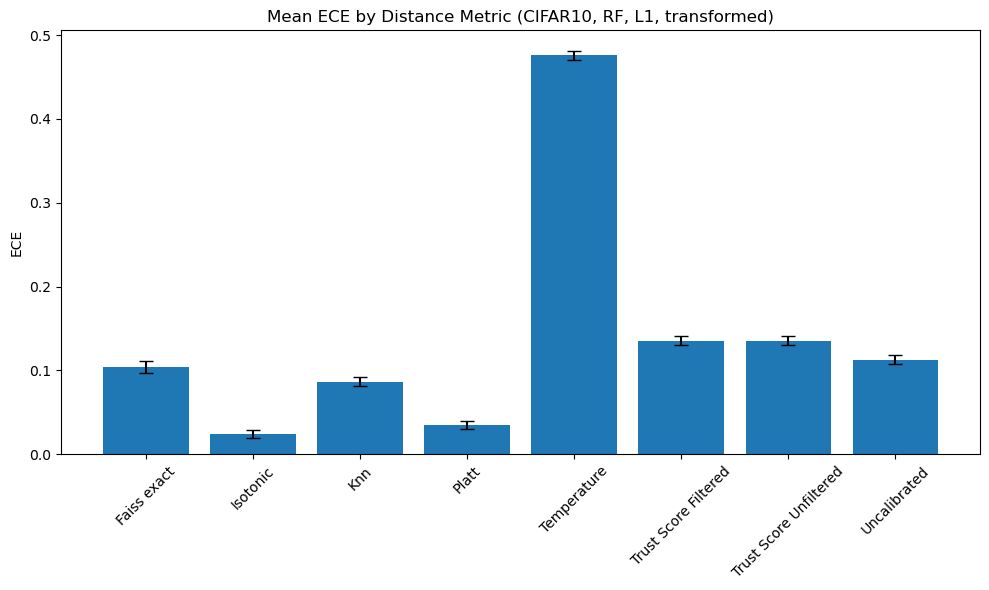

Plotting ECE for CIFAR10, RF, L2, transformed


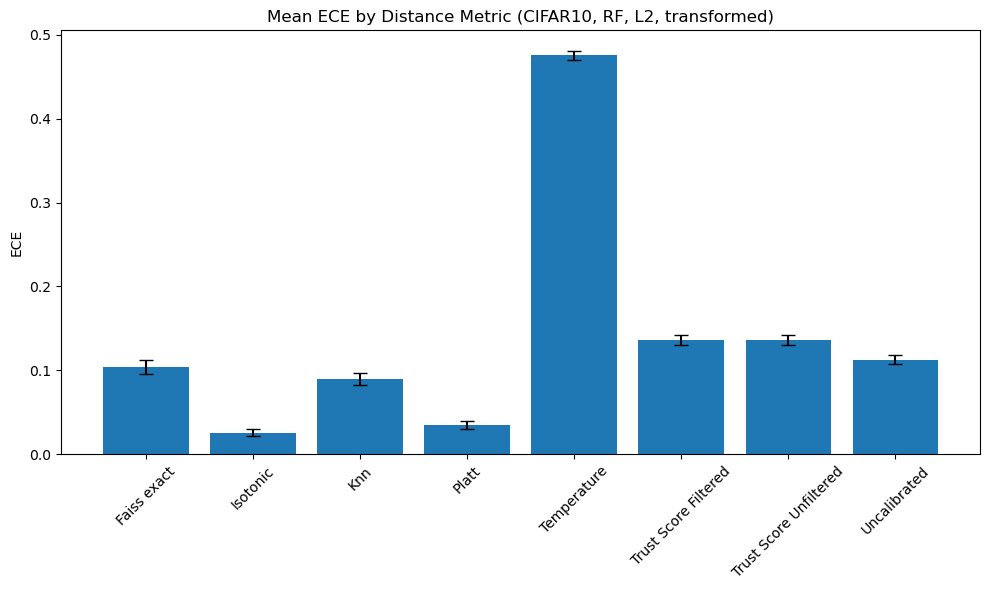

Plotting ECE for CIFAR10, RF, Linf, transformed


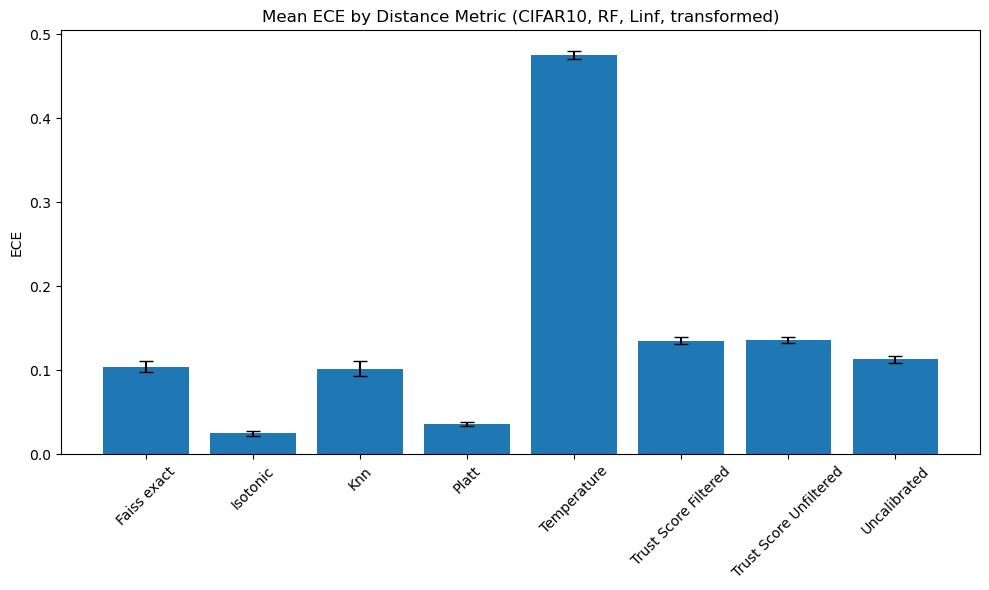

Plotting ECE for CIFAR10, RF, cosine, transformed


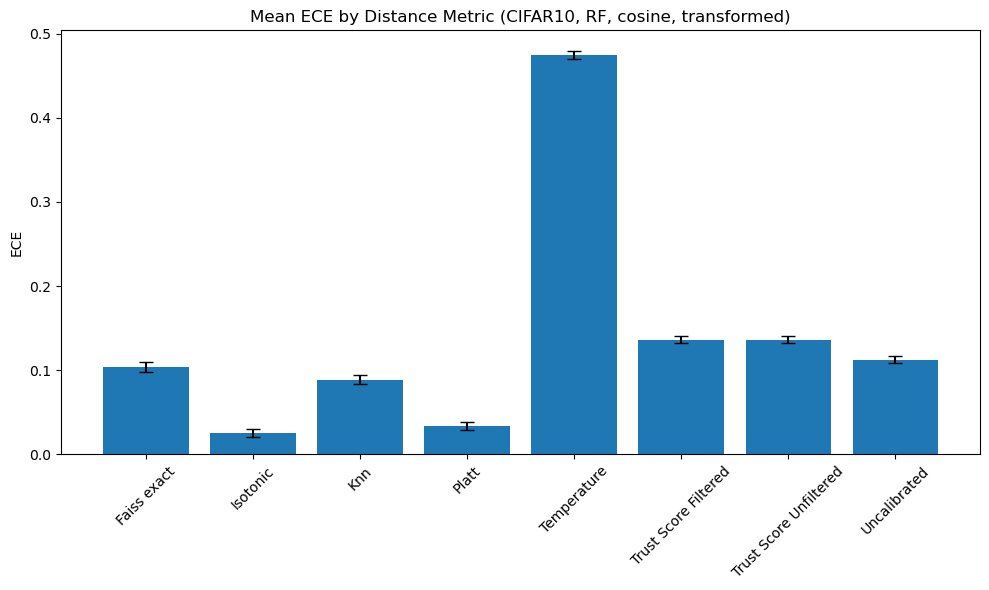

Plotting ECE for CIFAR10, cnn, L1, transformed


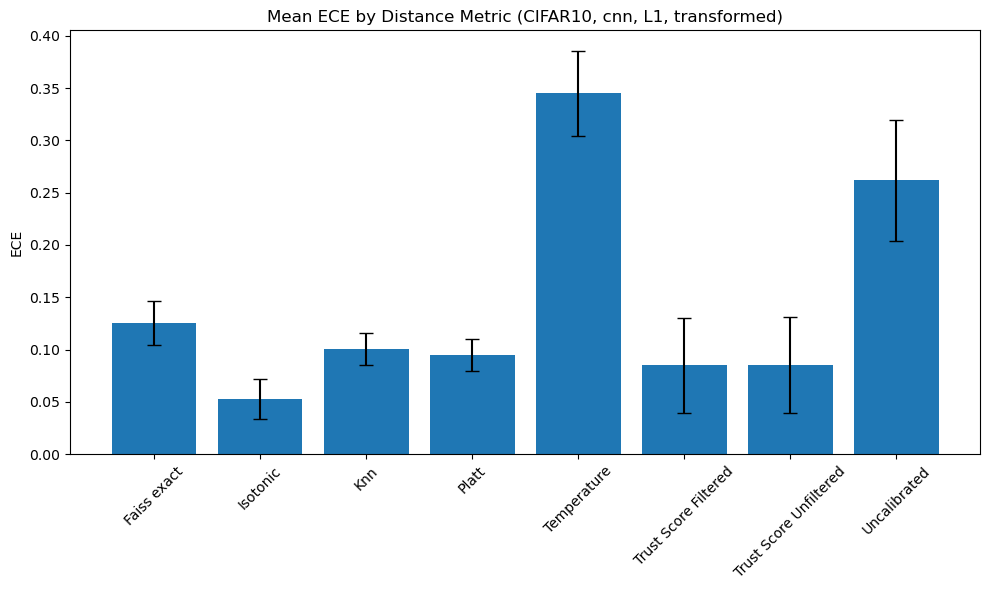

Plotting ECE for CIFAR10, cnn, L2, transformed


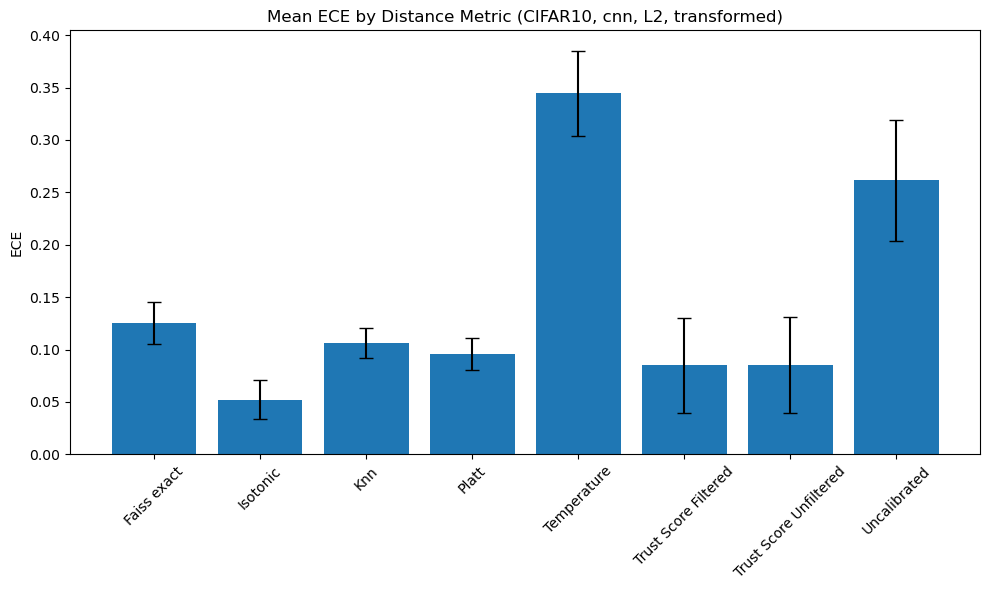

Plotting ECE for CIFAR10, cnn, Linf, transformed


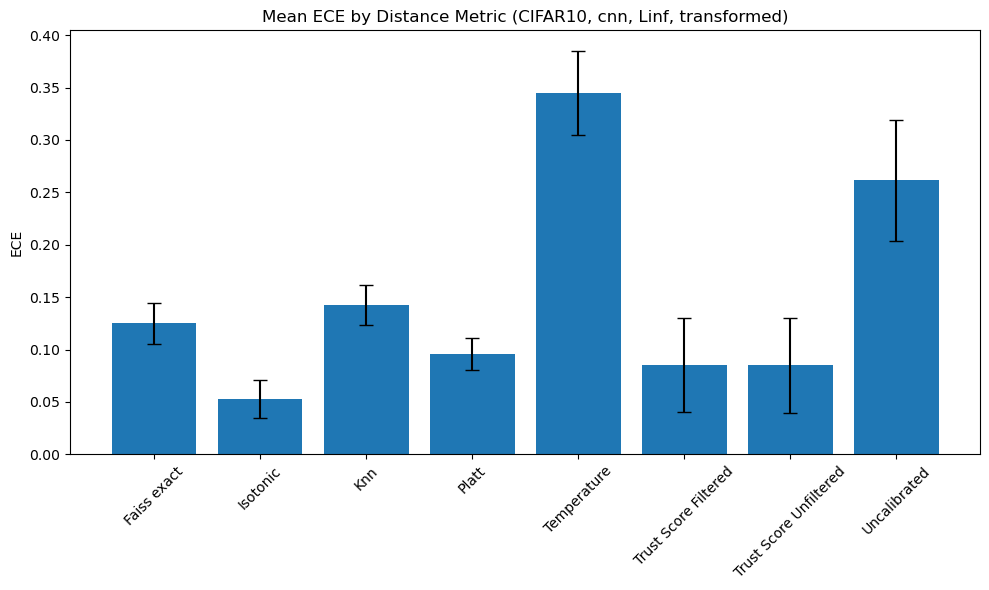

Plotting ECE for CIFAR10, cnn, cosine, transformed


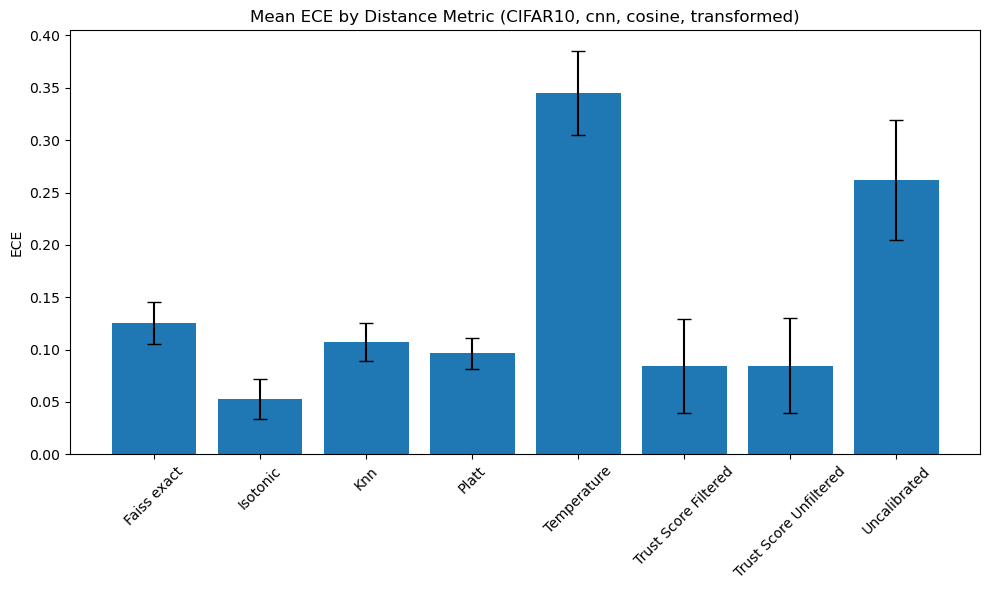

Plotting ECE for CIFAR10, GB, L1, non_transformed


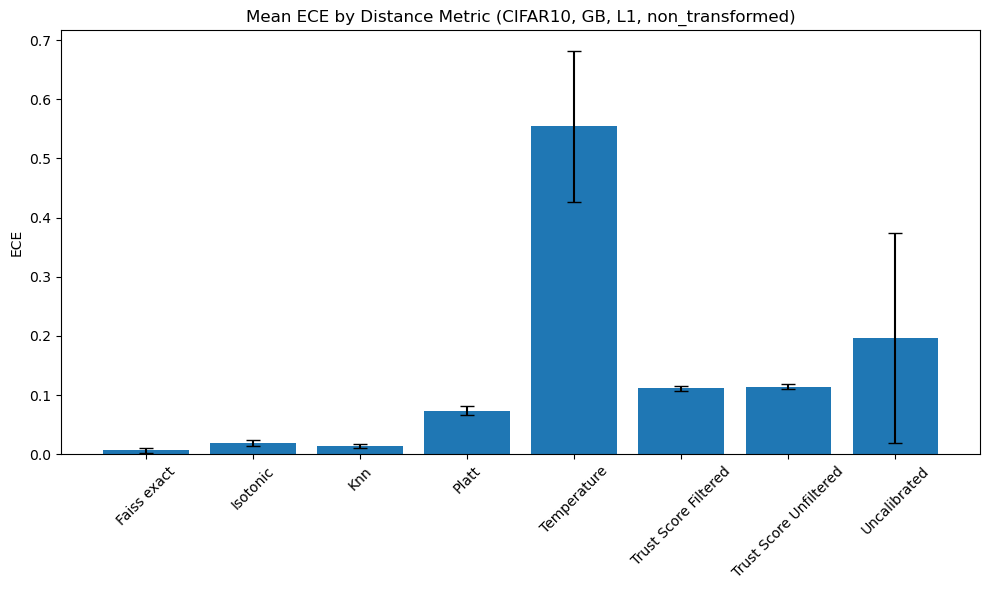

Plotting ECE for CIFAR10, GB, L2, non_transformed


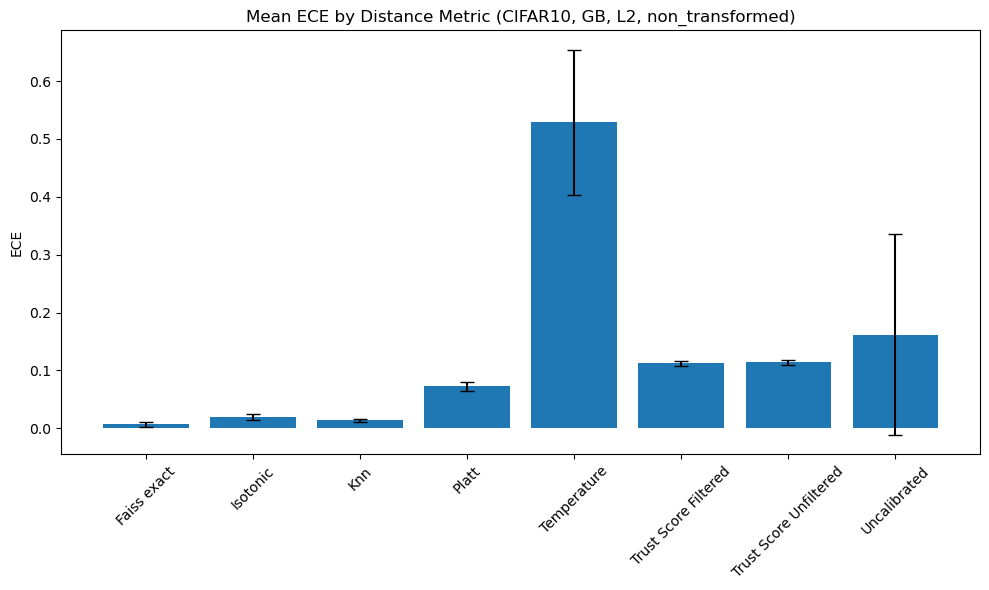

Plotting ECE for CIFAR10, GB, Linf, non_transformed


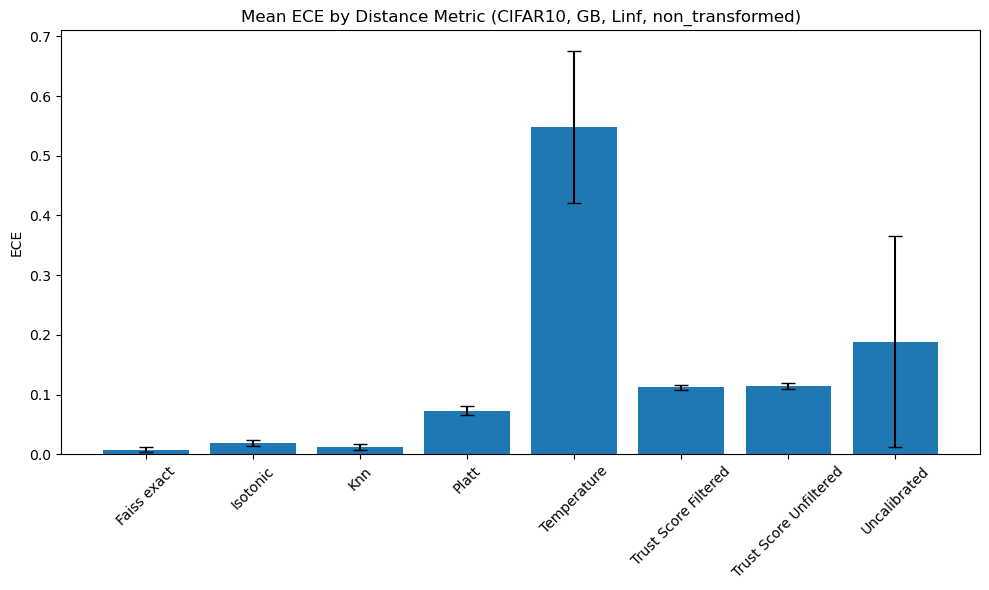

Plotting ECE for CIFAR10, GB, cosine, non_transformed


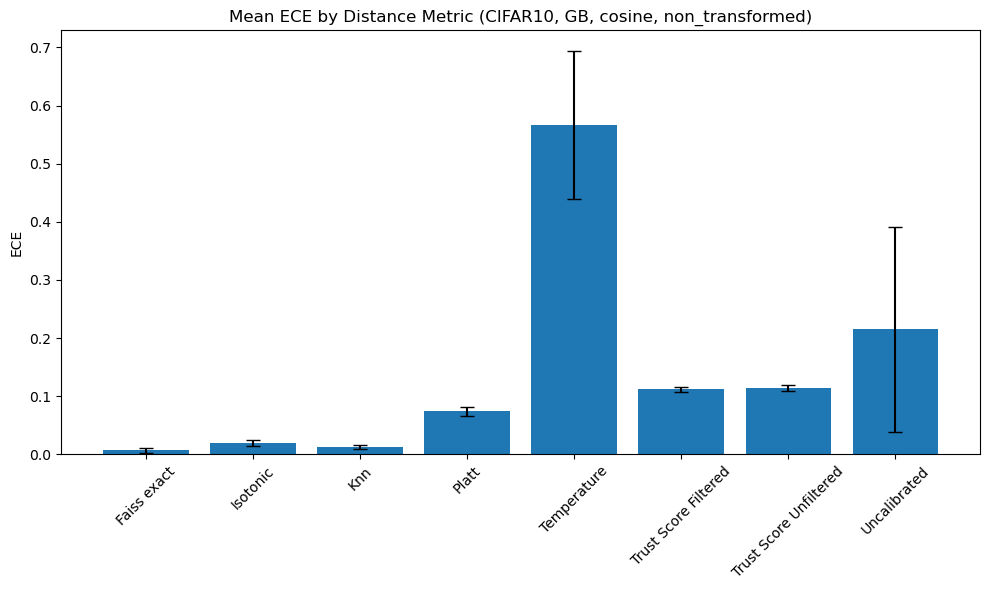

Plotting ECE for CIFAR10, RF, L1, non_transformed


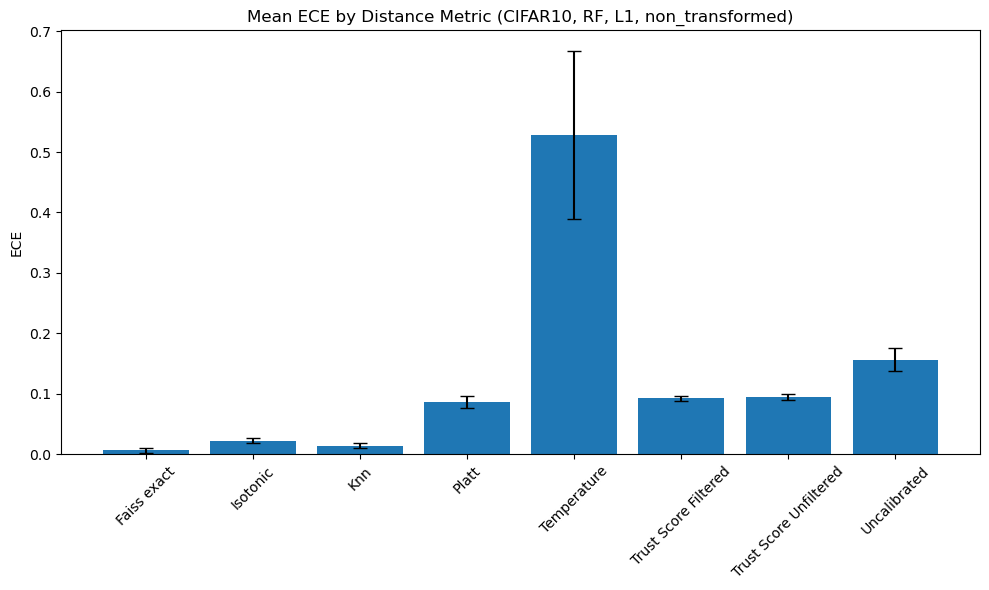

Plotting ECE for CIFAR10, RF, L2, non_transformed


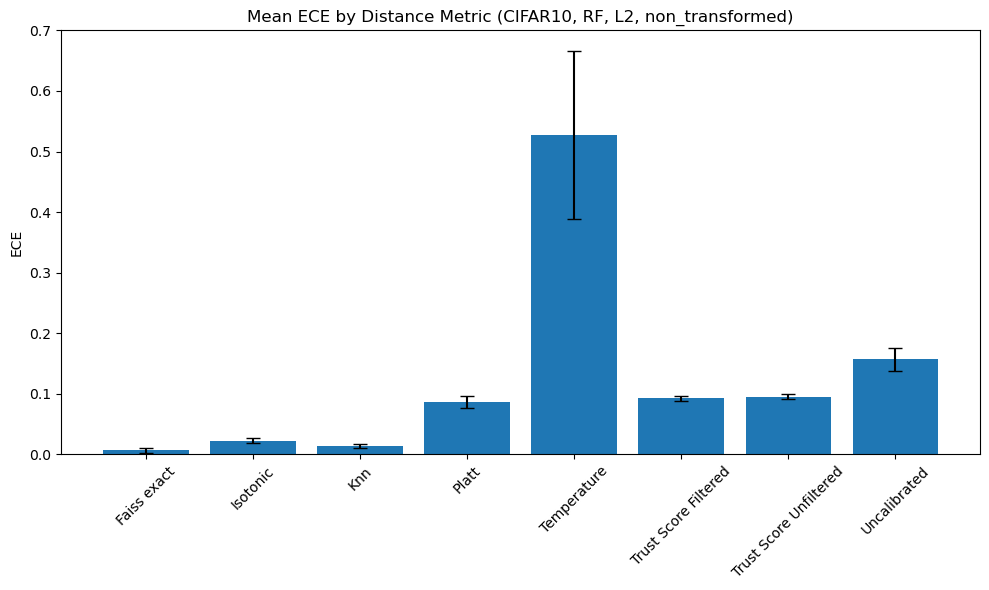

Plotting ECE for CIFAR10, RF, Linf, non_transformed


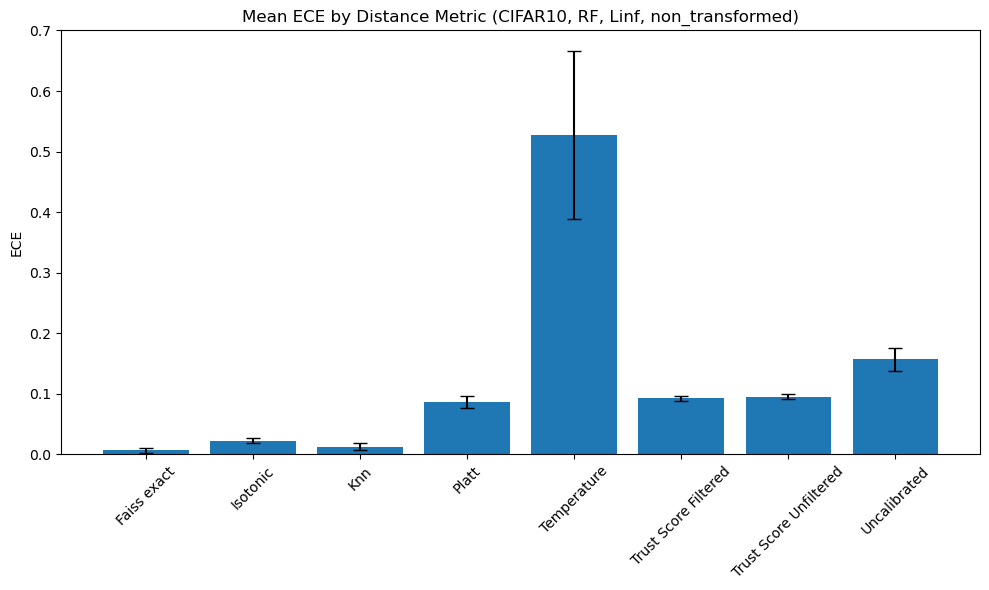

Plotting ECE for CIFAR10, RF, cosine, non_transformed


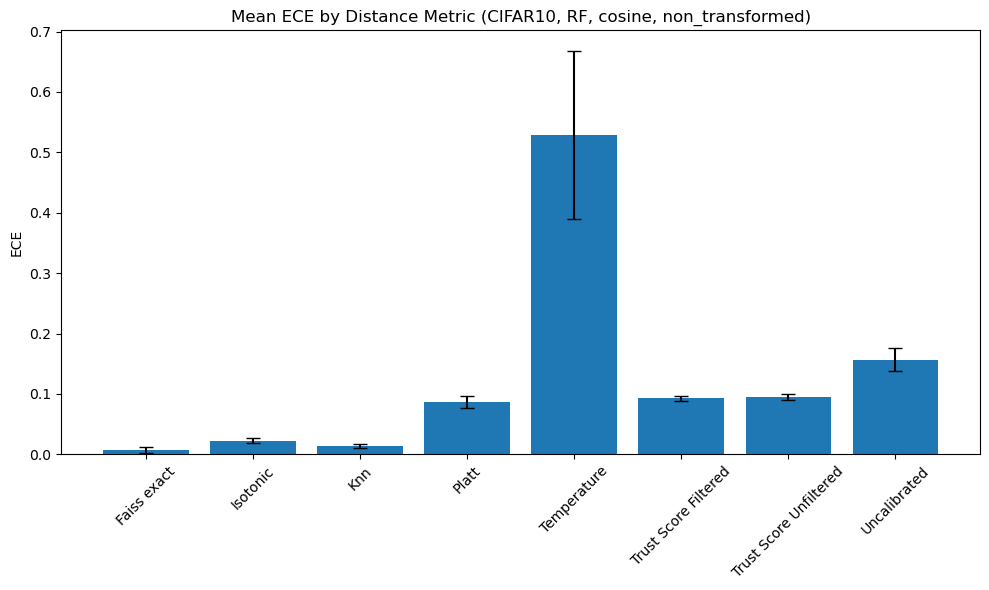

Plotting ECE for CIFAR10, cnn, L1, non_transformed


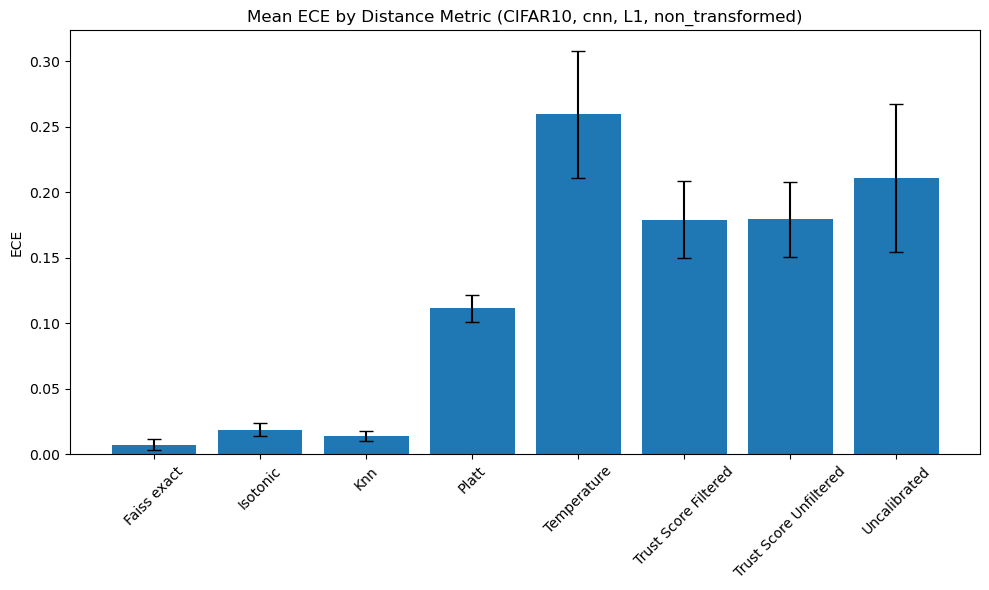

Plotting ECE for CIFAR10, cnn, L2, non_transformed


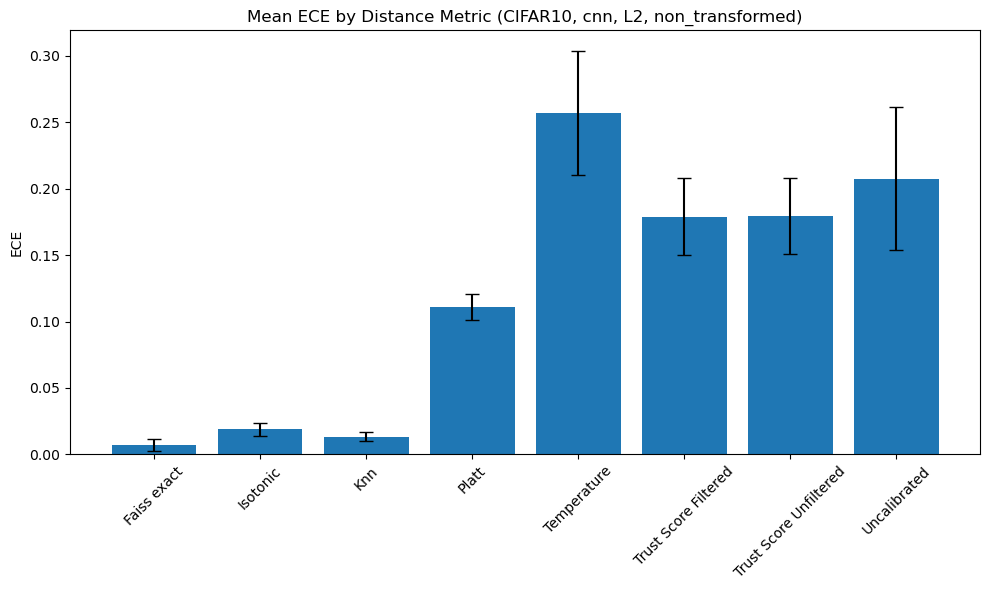

Plotting ECE for CIFAR10, cnn, Linf, non_transformed


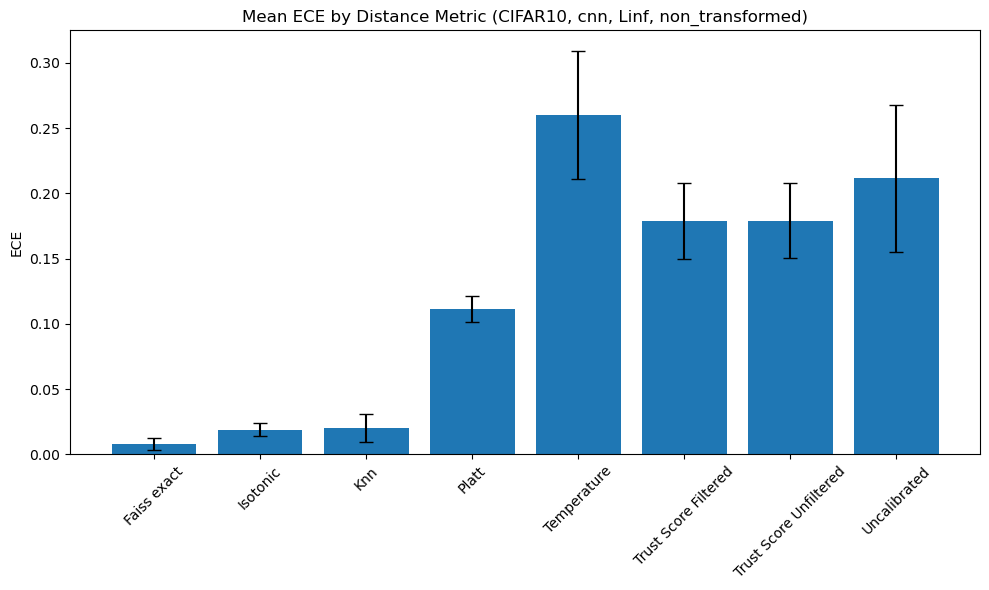

Plotting ECE for CIFAR10, cnn, cosine, non_transformed


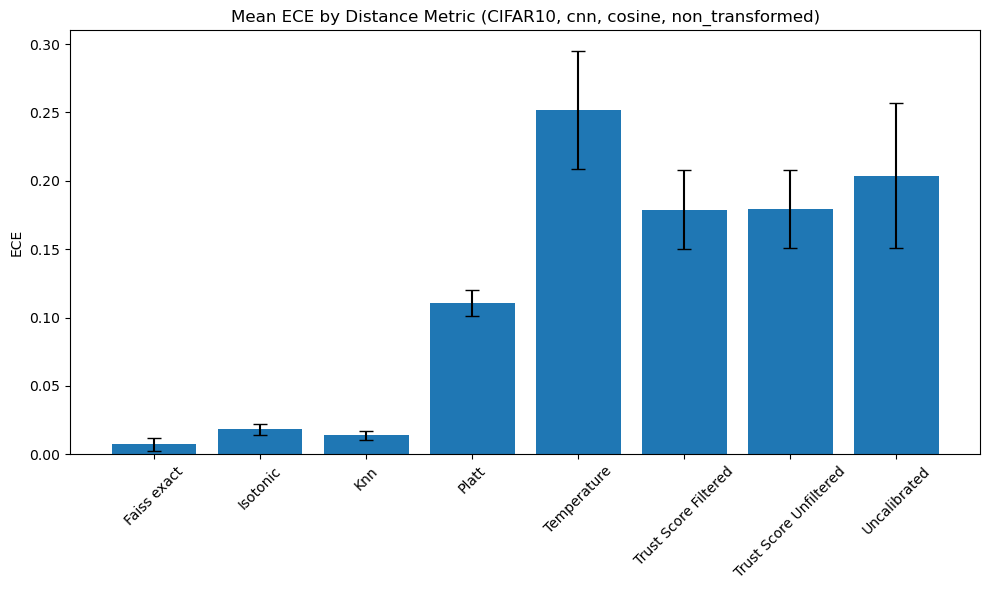

Plotting ECE for CIFAR100, cnn, L1, transformed
No data with count >= 10 for metric ECE. Skipping plot.
Plotting ECE for CIFAR100, cnn, L2, transformed
No data with count >= 10 for metric ECE. Skipping plot.
Plotting ECE for CIFAR100, cnn, Linf, transformed
No data with count >= 10 for metric ECE. Skipping plot.
Plotting ECE for CIFAR100, cnn, cosine, transformed
No data with count >= 10 for metric ECE. Skipping plot.
Plotting ECE for CIFAR100, GB, L1, non_transformed


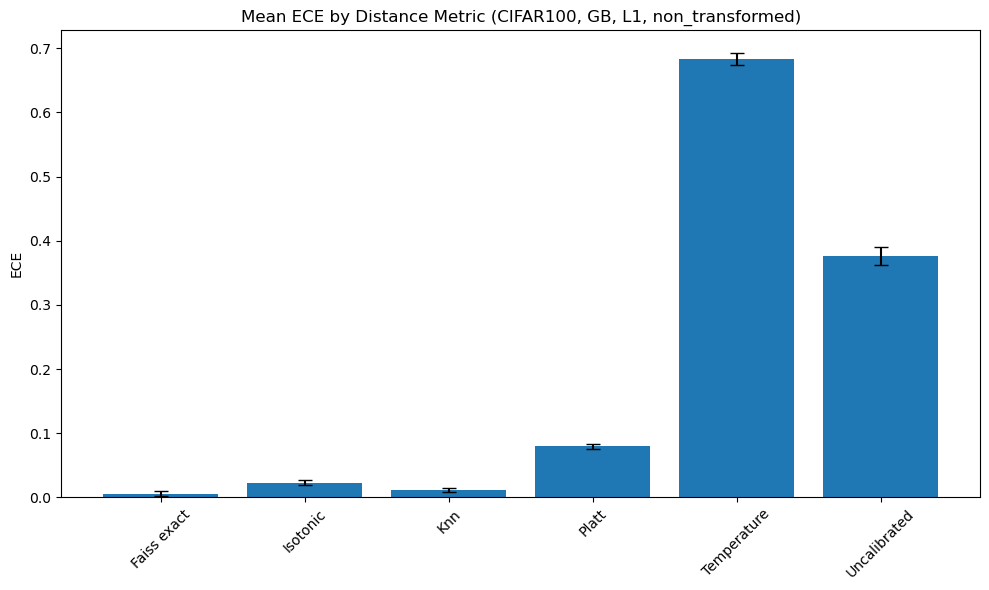

Plotting ECE for CIFAR100, GB, L2, non_transformed


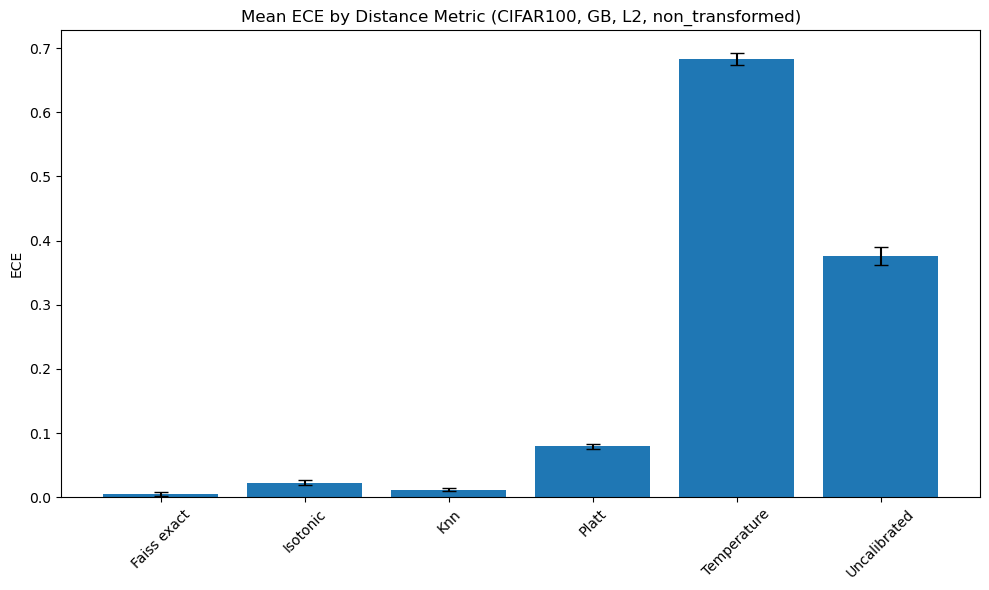

Plotting ECE for CIFAR100, GB, Linf, non_transformed


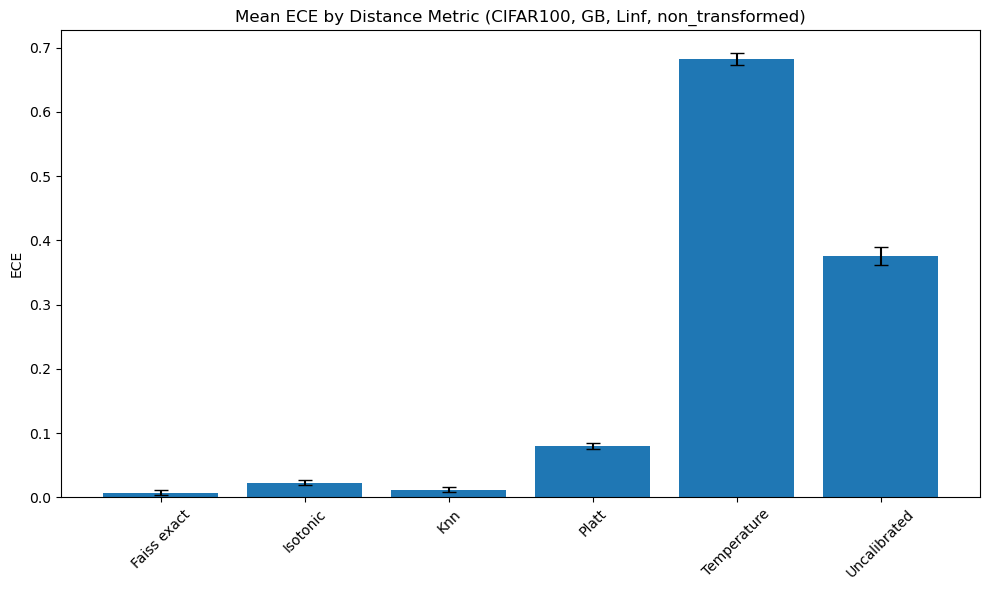

Plotting ECE for CIFAR100, GB, cosine, non_transformed


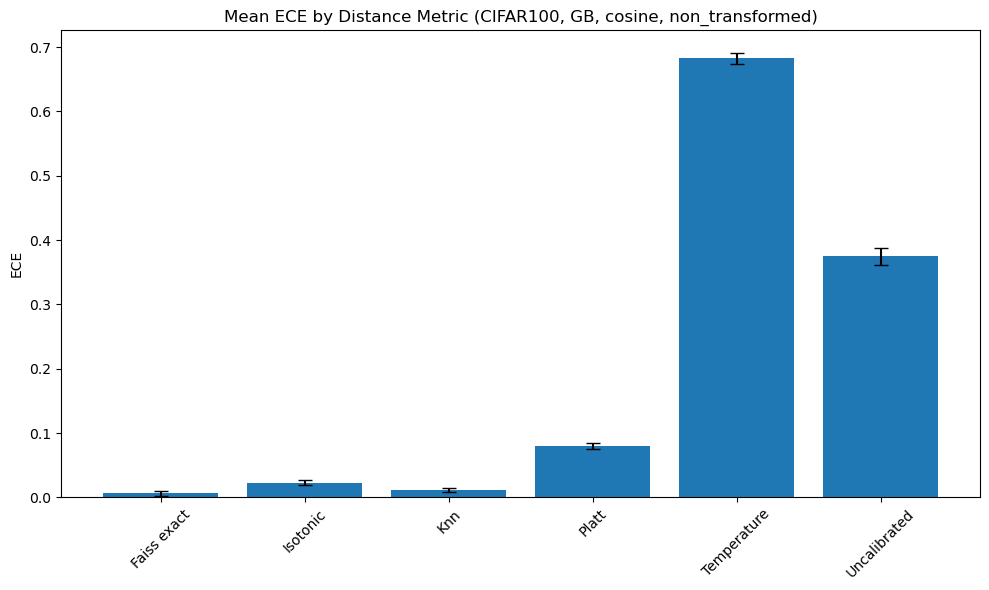

Plotting ECE for CIFAR100, RF, L1, non_transformed


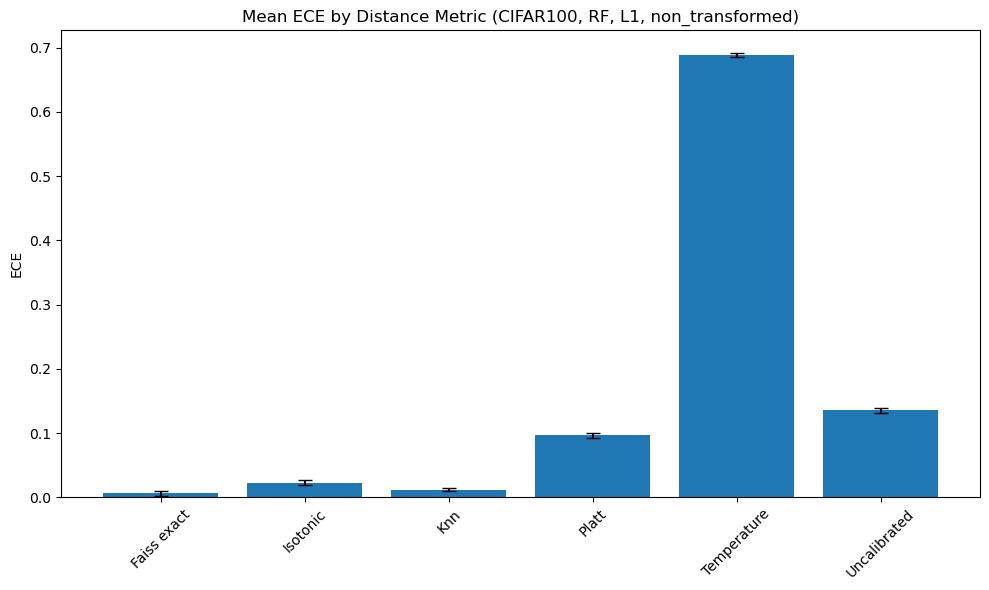

Plotting ECE for CIFAR100, RF, L2, non_transformed


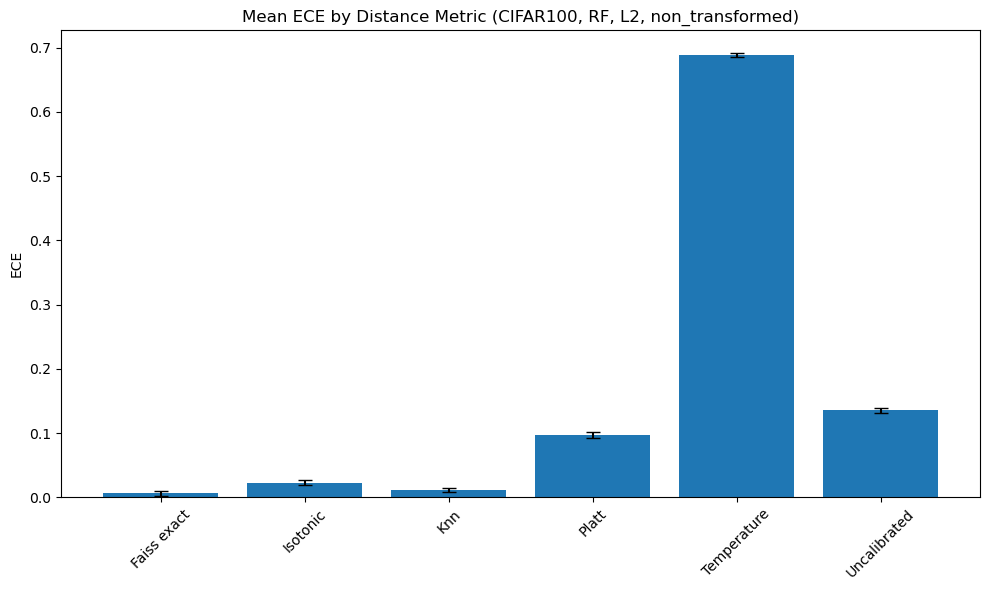

Plotting ECE for CIFAR100, RF, Linf, non_transformed


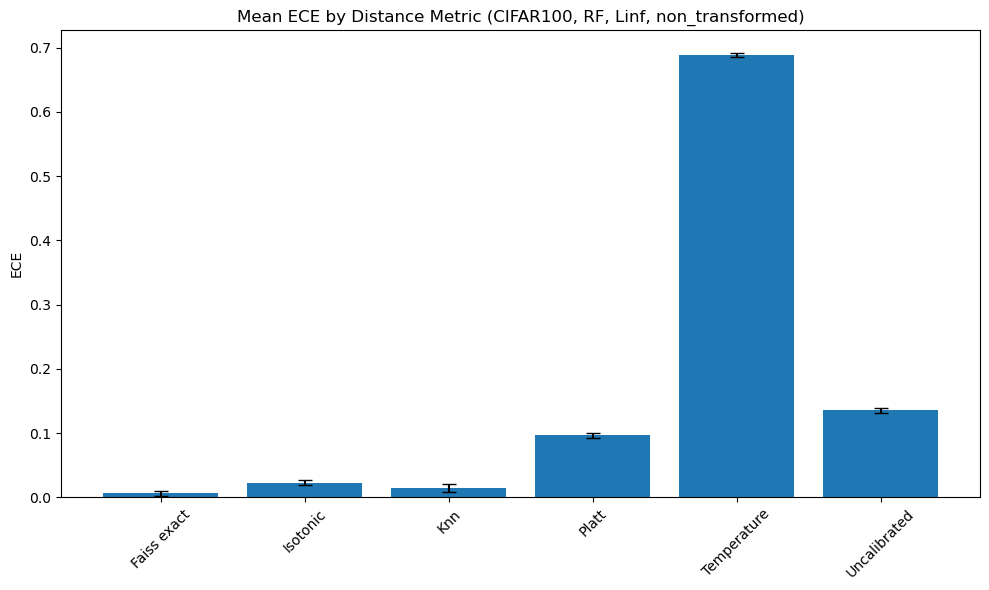

Plotting ECE for CIFAR100, RF, cosine, non_transformed


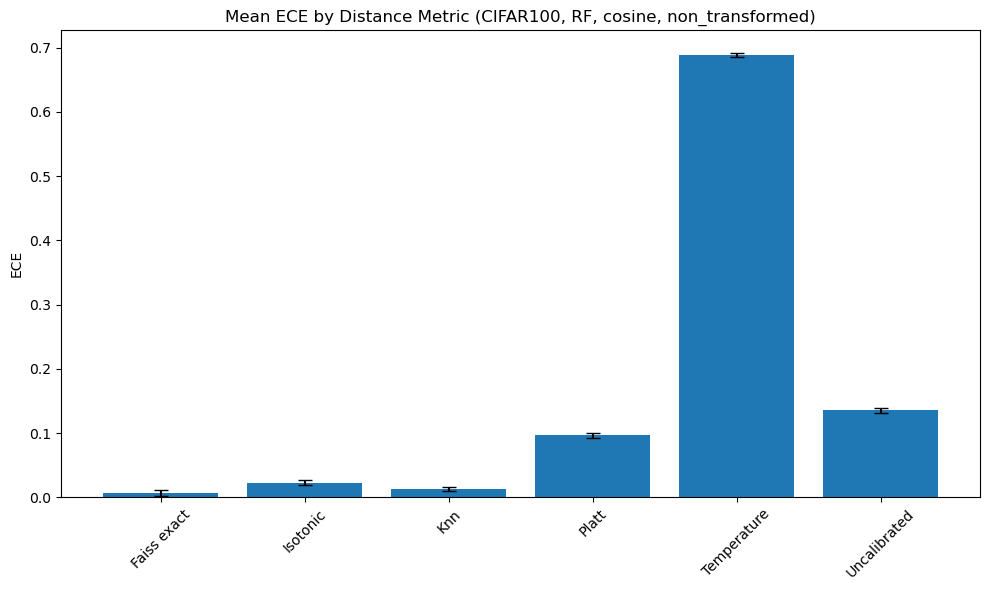

Plotting ECE for CIFAR100, cnn, L1, non_transformed


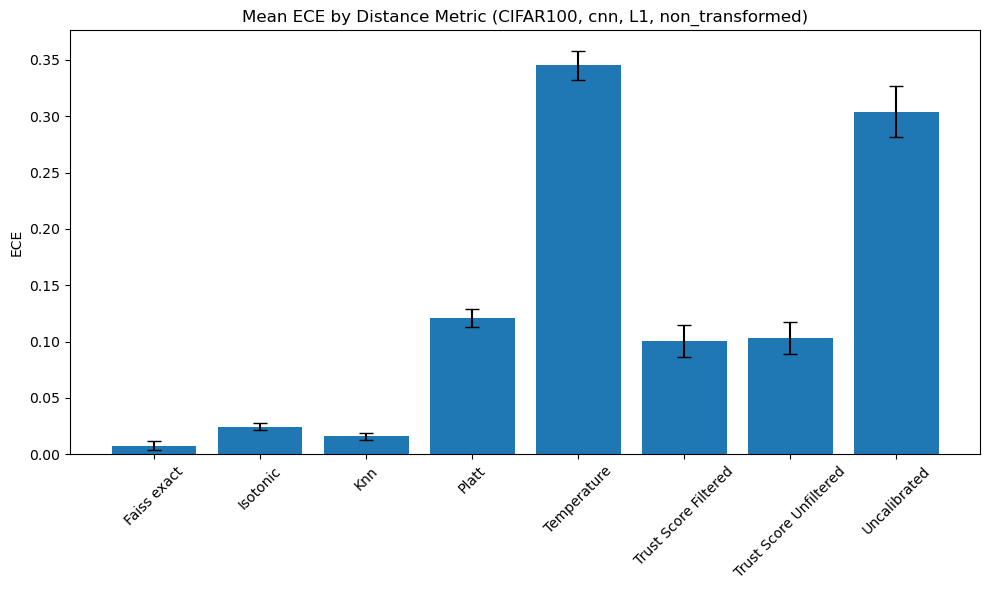

Plotting ECE for CIFAR100, cnn, L2, non_transformed


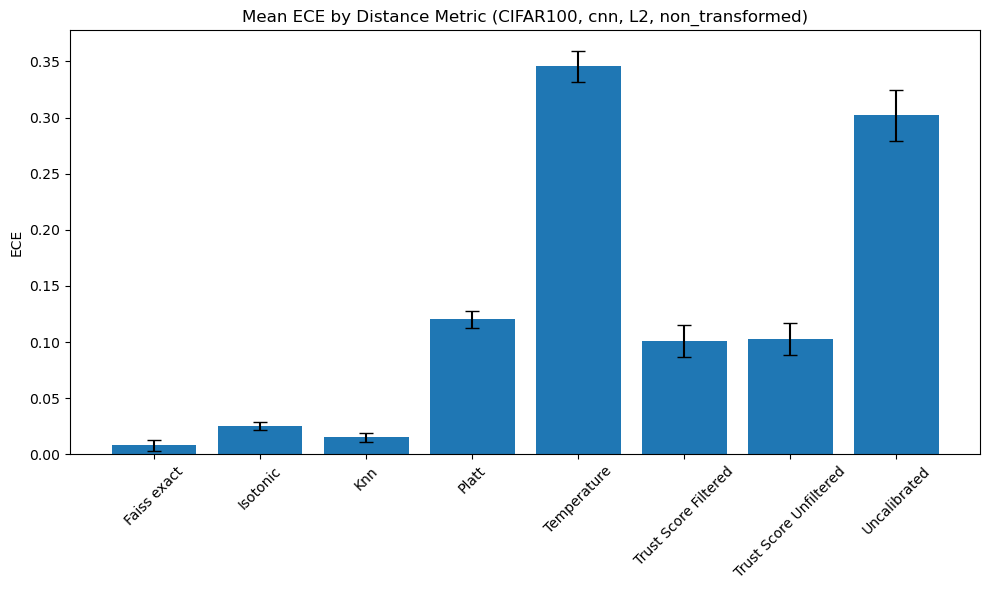

Plotting ECE for CIFAR100, cnn, Linf, non_transformed


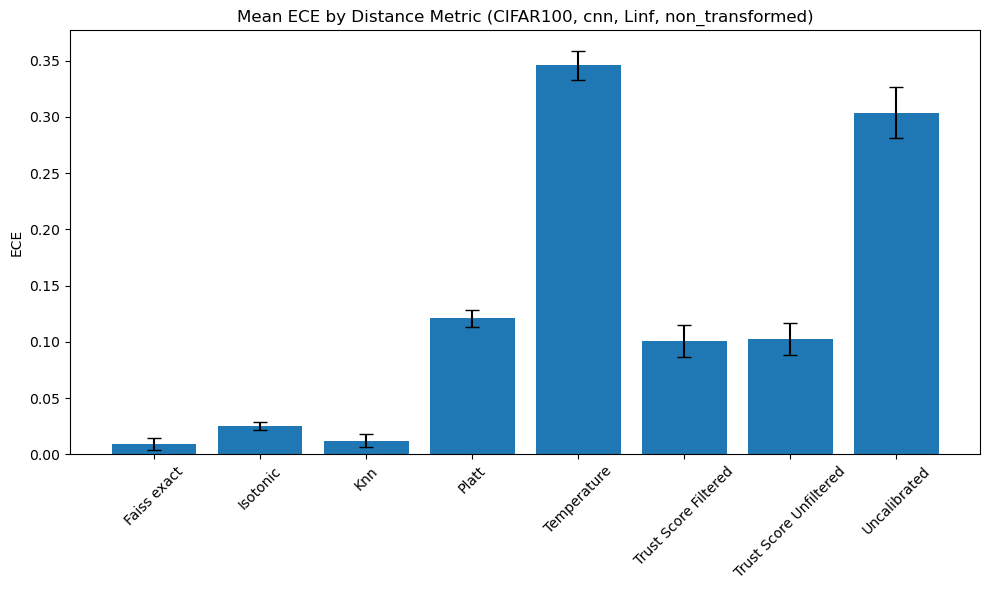

Plotting ECE for CIFAR100, cnn, cosine, non_transformed


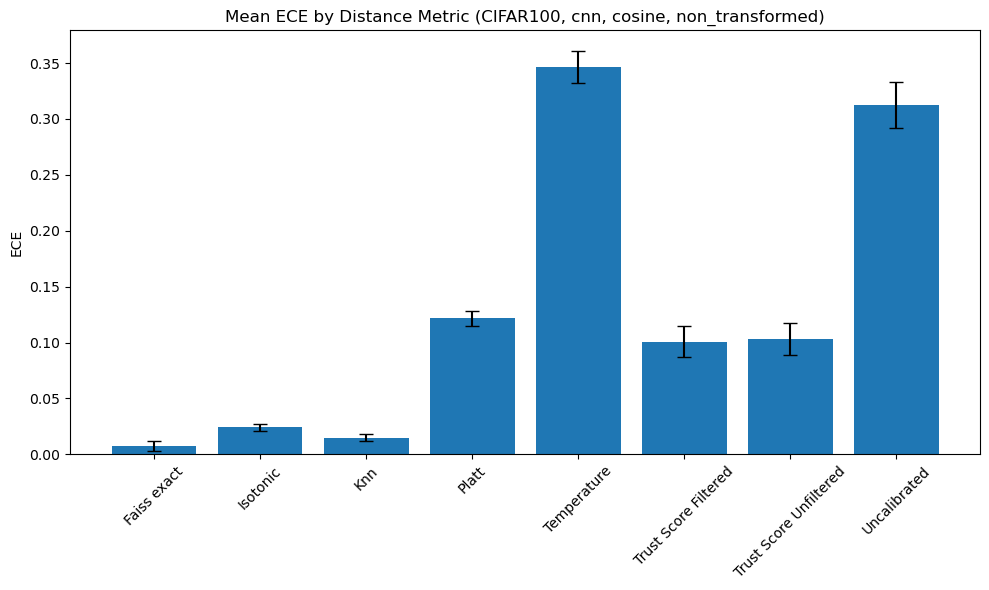

In [6]:
import matplotlib.pyplot as plt

def plot_metric(data, metric, title, group_column='Metric', count_threshold=10):
    """
    Plots a bar chart for a specified metric.

    Parameters:
        data (pd.DataFrame): DataFrame with aggregated results.
        metric (str): The metric to plot (e.g., 'ECE').
        title (str): Title of the plot.
        group_column (str): Column to group by for the plot (default is 'Metric').
        count_threshold (int): Minimum count required for plotting (default is 10).
    """
    # Filter data based on count threshold
    filtered_data = data[data[(metric, 'count')] >= count_threshold]
    if filtered_data.empty:
        print(f"No data with count >= {count_threshold} for metric {metric}. Skipping plot.")
        return
    
    # Extract necessary data
    mean_values = filtered_data[(metric, 'mean')]
    std_values = filtered_data[(metric, 'std')]
    groups = filtered_data[group_column]

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.bar(groups, mean_values, yerr=std_values, capsize=5)
    plt.title(title)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_metrics_for_datasets(datasets, combined_files, metric, title_prefix, count_threshold=10, group_column='Metric'):
    """
    Plots the specified metric for all datasets.

    Parameters:
        datasets (list): List of dataset names (e.g., ['MNIST', 'CIFAR10']).
        combined_files (dict): Dictionary containing paths to combined result files.
        metric (str): The metric to plot (e.g., 'ECE').
        title_prefix (str): Prefix for the plot title.
        count_threshold (int): Minimum count required for plotting (default is 10).
        group_column (str): Column to group by for the plot (default is 'Metric').
    """
    for dataset in datasets:
        for transformed_type, file_template in combined_files.items():
            for model in models:
                for metric_type in distance_metrics:
                    file_path = file_template.format(dataset=dataset, model=model, metric=metric_type)
                    if os.path.exists(file_path):
                        # Load aggregated data
                        aggregated_data = aggregate_results(file_path, group_by_columns, aggregate_columns)

                        # Plot metric
                        plot_title = f"{title_prefix} ({dataset}, {model}, {metric_type}, {transformed_type})"
                        print(f"Plotting {metric} for {dataset}, {model}, {metric_type}, {transformed_type}")
                        plot_metric(aggregated_data, metric, plot_title, group_column, count_threshold)

# Define metric to plot and title prefix
metric_to_plot = 'ECE'
title_prefix = "Mean ECE by Distance Metric"

# Plot metrics for all datasets
plot_metrics_for_datasets(datasets, combined_files, metric_to_plot, title_prefix)


Title: Statistical Comparison of Calibration Methods

In this analysis, we aim to statistically evaluate the calibration performance of FAISS (approximate and exact) and KNN (non-binned) methods against Trust Score (filtered and unfiltered). We will use ANOVA and pairwise t-tests to determine if there are significant differences in Expected Calibration Error (ECE) across methods.

In [6]:
# Import required libraries
import pandas as pd
from scipy.stats import f_oneway, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt


Loading Data and Filtering Relevant Metrics

In this step, we filter the relevant methods (FAISS, KNN, and Trust Score) from the aggregated dataset.

In [7]:
# Load aggregated data
aggregated_data = pd.read_csv('/cs/cs_groups/cliron_group/Calibrato/combined_results_non_transformed_CIFAR10.csv')

# Select relevant methods for comparison
methods_to_compare = ['Faiss approximate', 'Faiss exact', 'Knn', 'Trust Score Filtered', 'Trust Score Unfiltered']

# Filter the aggregated data
comparison_data = aggregated_data[aggregated_data['Metric'].isin(methods_to_compare)]

# Verify filtered data
print(comparison_data.head())


                    Metric       ECE       MCE  Brier Score   Log Loss  \
4     Trust Score Filtered  0.207650  0.425047     0.054704  11.237844   
5   Trust Score Unfiltered  0.207886  0.425258     0.054687  11.237541   
6              Faiss exact  0.006324  0.967262     0.049783   1.267804   
7                      Knn  0.014430  0.540483     0.048222   1.232515   
12    Trust Score Filtered  0.207650  0.425047     0.054704  11.237844   

         ACE  Binned Likelihood      CRSP  Sharpness   Entropy       NLL  \
4   0.113644        -712.851420  0.248871   0.494692  0.347789  8.729478   
5   0.114874        -717.448307  0.248700   0.494827  0.347743  8.729175   
6   0.095869       -2042.274306  0.209510   0.697509  1.276982  1.267103   
7   0.058776       -3775.798435  0.195533   0.699064  1.231986  1.231113   
12  0.113644        -712.851420  0.248871   0.494692  0.347789  8.729478   

    Calibration Time (s)  Train Size  Validation Size  Test Size  Dataset  \
4            2201.348

Performing ANOVA Test

We perform a one-way ANOVA test to compare the means of ECE across selected methods. ANOVA will help us determine if there is a significant difference between the groups.

In [8]:
# Extract ECE values for each method
faiss_approximate = comparison_data[comparison_data['Metric'] == 'Faiss approximate']['ECE']
faiss_exact = comparison_data[comparison_data['Metric'] == 'Faiss exact']['ECE']
knn = comparison_data[comparison_data['Metric'] == 'Knn']['ECE']
trust_score_filtered = comparison_data[comparison_data['Metric'] == 'Trust Score Filtered']['ECE']
trust_score_unfiltered = comparison_data[comparison_data['Metric'] == 'Trust Score Unfiltered']['ECE']

# Perform ANOVA
anova_result = f_oneway(faiss_approximate, faiss_exact, knn, trust_score_filtered, trust_score_unfiltered)

# Display results
print(f"ANOVA Test Result: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")


ANOVA Test Result: F-statistic = 2649.383663183105, p-value = 0.0


Performing Pairwise T-tests

To determine which methods are significantly different, we perform pairwise t-tests between each pair of methods.

In [9]:
# Perform pairwise t-tests
ttest_results = {}
pairs = [
    ('Faiss approximate', 'Trust Score Filtered'),
    ('Faiss exact', 'Trust Score Filtered'),
    ('Knn', 'Trust Score Filtered'),
    ('Faiss approximate', 'Trust Score Unfiltered'),
    ('Faiss exact', 'Trust Score Unfiltered'),
    ('Knn', 'Trust Score Unfiltered')
]

for method1, method2 in pairs:
    group1 = comparison_data[comparison_data['Metric'] == method1]['ECE']
    group2 = comparison_data[comparison_data['Metric'] == method2]['ECE']
    ttest_result = ttest_ind(group1, group2)
    ttest_results[(method1, method2)] = ttest_result

# Display results
for (method1, method2), result in ttest_results.items():
    print(f"T-test between {method1} and {method2}: t-statistic = {result.statistic}, p-value = {result.pvalue}")


T-test between Faiss approximate and Trust Score Filtered: t-statistic = -2.858963363019826, p-value = 0.004435636735207107
T-test between Faiss exact and Trust Score Filtered: t-statistic = -72.77857257414522, p-value = 0.0
T-test between Knn and Trust Score Filtered: t-statistic = -69.25892171442096, p-value = 0.0
T-test between Faiss approximate and Trust Score Unfiltered: t-statistic = -3.064190446051681, p-value = 0.002305667357100156
T-test between Faiss exact and Trust Score Unfiltered: t-statistic = -74.92698015316776, p-value = 0.0
T-test between Knn and Trust Score Unfiltered: t-statistic = -71.3283264944334, p-value = 0.0


Visualizing ECE Distribution

We now visualize the ECE distribution for each method using a boxplot. This will provide a clear picture of the differences in calibration performance.

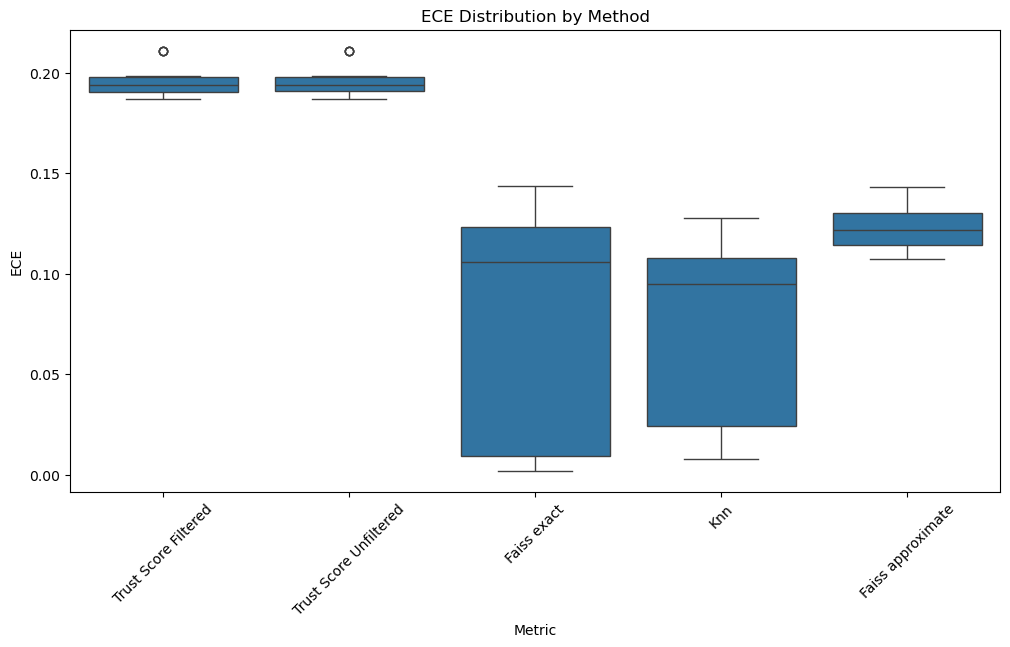

In [30]:
# Boxplot of ECE values
plt.figure(figsize=(12, 6))
sns.boxplot(x='Metric', y='ECE', data=comparison_data)
plt.title('ECE Distribution by Method')
plt.xticks(rotation=45)
plt.ylabel('ECE')
plt.show()


Processing Aggregated Results for Multiple Datasets

We will iterate through the combined results for both transformed and non-transformed datasets and perform statistical analyses for each file.

In [10]:
# Define paths for aggregated results
file_paths = [
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_non_transformed_CIFAR10.csv",
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_non_transformed_CIFAR100.csv",
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_non_transformed_Fashion_MNIST.csv",
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_non_transformed_MNIST.csv",
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_transformed_CIFAR10.csv",
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_transformed_CIFAR100.csv",
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_transformed_Fashion_MNIST.csv",
    "/cs/cs_groups/cliron_group/Calibrato/combined_results_transformed_MNIST.csv",
]

# Define relevant methods for comparison
methods_to_compare = ['Faiss approximate', 'Faiss exact', 'Knn', 'Trust Score Filtered', 'Trust Score Unfiltered']


Function to Load and Filter Data

This function loads data from a file, filters the relevant methods, and returns the filtered DataFrame.

In [11]:
def filter_data(file_path, methods):
    """
    Load and filter aggregated data for relevant methods.

    Parameters:
        file_path (str): Path to the aggregated results file.
        methods (list): List of methods to include in the comparison.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Load data
    data = pd.read_csv(file_path)
    
    # Filter relevant methods
    filtered_data = data[data['Metric'].isin(methods)]
    
    return filtered_data


Processing Each File and Running Statistical Analysis

We process each file, perform ANOVA and t-tests, and save the results.

In [12]:
# Store results
anova_results = []
ttest_results = []

for file_path in file_paths:
    # Extract dataset name from file path
    dataset_name = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    transformed = 'transformed' in file_path
    
    # Load and filter data
    filtered_data = filter_data(file_path, methods_to_compare)
    
    # Extract ECE values for each method
    ece_values = {method: filtered_data[filtered_data['Metric'] == method]['ECE'] for method in methods_to_compare}
    
    # Perform ANOVA
    anova_result = f_oneway(*ece_values.values())
    anova_results.append({
        'Dataset': dataset_name,
        'Transformed': transformed,
        'F-statistic': anova_result.statistic,
        'p-value': anova_result.pvalue
    })
    
    # Perform pairwise t-tests
    for i, method1 in enumerate(methods_to_compare):
        for method2 in methods_to_compare[i+1:]:
            ttest_result = ttest_ind(ece_values[method1], ece_values[method2])
            ttest_results.append({
                'Dataset': dataset_name,
                'Transformed': transformed,
                'Method 1': method1,
                'Method 2': method2,
                't-statistic': ttest_result.statistic,
                'p-value': ttest_result.pvalue
            })


/tmp/ipykernel_3966814/1903347676.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_result = f_oneway(*ece_values.values())
/tmp/ipykernel_3966814/1903347676.py:28: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_result = ttest_ind(ece_values[method1], ece_values[method2])
/tmp/ipykernel_3966814/1903347676.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_result = f_oneway(*ece_values.values())
/tmp/ipykernel_3966814/1903347676.py:28: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_result = ttest_ind(ece_values[method1], ece_values[method2])
/tmp/ipykernel_3966814/190

Saving and Displaying Results

We save the ANOVA and t-test results for future reference and display a summary.

In [13]:
# Convert results to DataFrames
anova_df = pd.DataFrame(anova_results)
ttest_df = pd.DataFrame(ttest_results)

# Save results to CSV
anova_df.to_csv('/cs/cs_groups/cliron_group/Calibrato/anova_results.csv', index=False)
ttest_df.to_csv('/cs/cs_groups/cliron_group/Calibrato/ttest_results.csv', index=False)

# Display results
print("ANOVA Results:")
display(anova_df)

print("\nPairwise T-test Results:")
display(ttest_df)


ANOVA Results:


,Dataset,Transformed,F-statistic,p-value
0,CIFAR10,True,2649.383663,0.0
1,CIFAR100,True,NaN,NaN
2,MNIST,True,16394.036817,0.0
3,MNIST,True,32313.392993,0.0
4,CIFAR10,True,NaN,NaN
5,CIFAR100,True,NaN,NaN
6,MNIST,True,NaN,NaN
7,MNIST,True,NaN,NaN



Pairwise T-test Results:


,Dataset,Transformed,Method 1,Method 2,t-statistic,p-value
0,CIFAR10,True,Faiss approximate,Faiss exact,32.283099,8.361924e-141
1,CIFAR10,True,Faiss approximate,Knn,30.108629,3.802370e-129
2,CIFAR10,True,Faiss approximate,Trust Score Filtered,-2.858963,4.435637e-03
3,CIFAR10,True,Faiss approximate,Trust Score Unfiltered,-3.064190,2.305667e-03
4,CIFAR10,True,Faiss exact,Knn,-7.678216,3.062973e-14
...,...,...,...,...,...,...
75,MNIST,True,Faiss exact,Trust Score Filtered,15.925181,8.077601e-52
76,MNIST,True,Faiss exact,Trust Score Unfiltered,14.679370,6.455052e-45
77,MNIST,True,Knn,Trust Score Filtered,-29.080669,2.746015e-140
78,MNIST,True,Knn,Trust Score Unfiltered,-31.227731,2.456146e-156


Visualizing Results

We can also visualize the ECE distributions using boxplots for each dataset and transformation type.

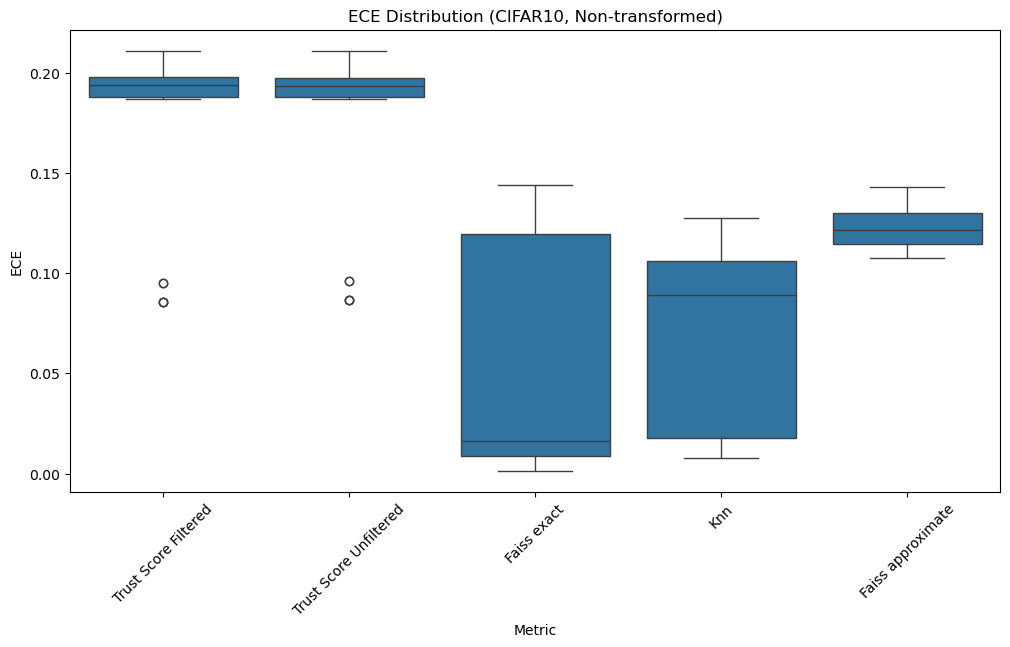

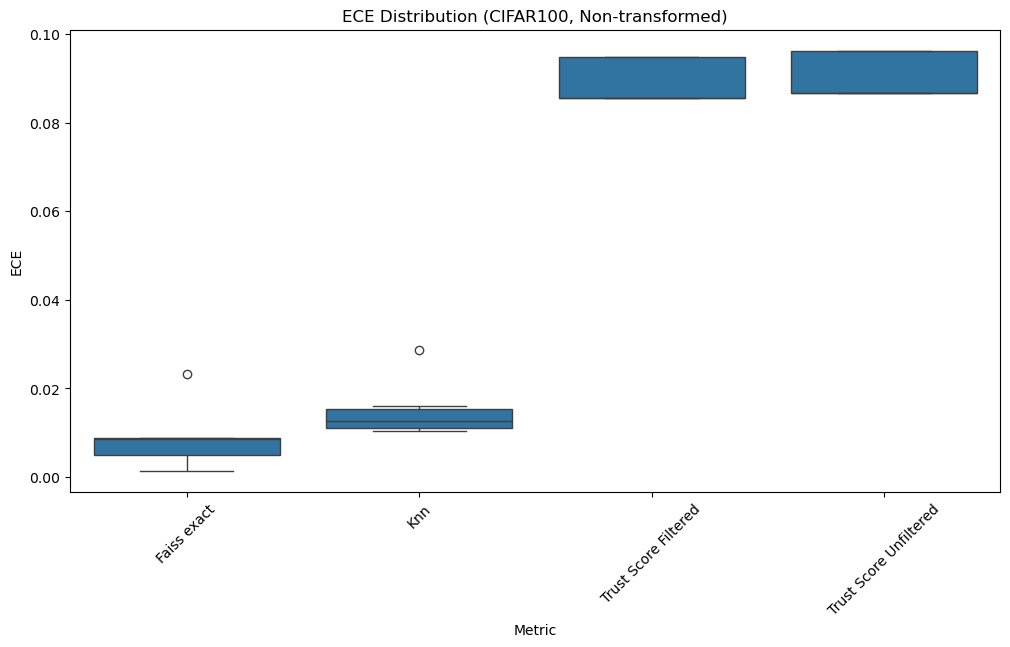

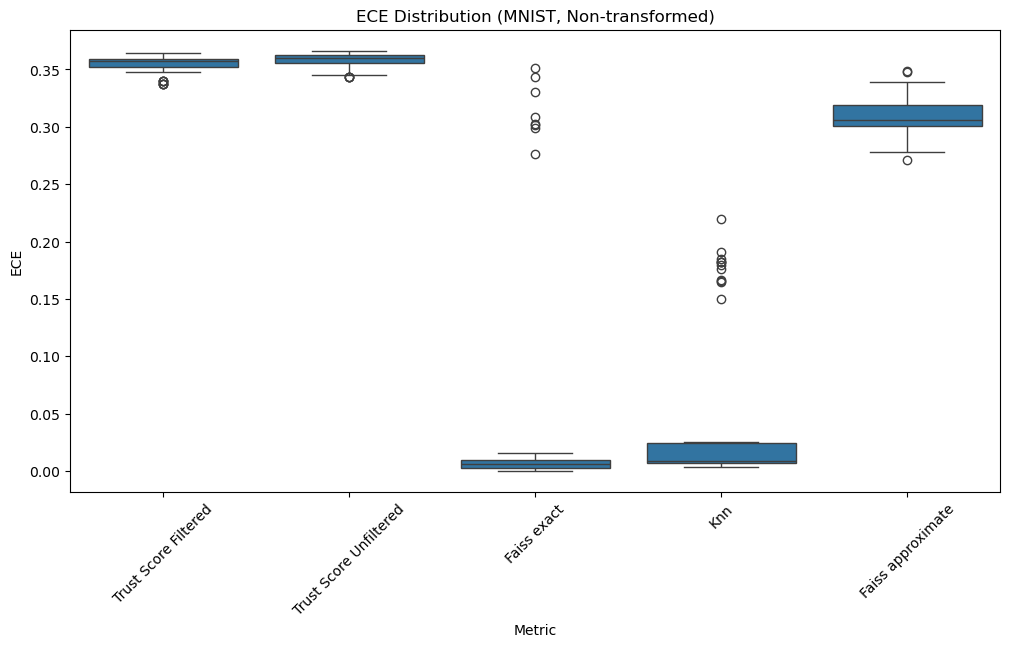

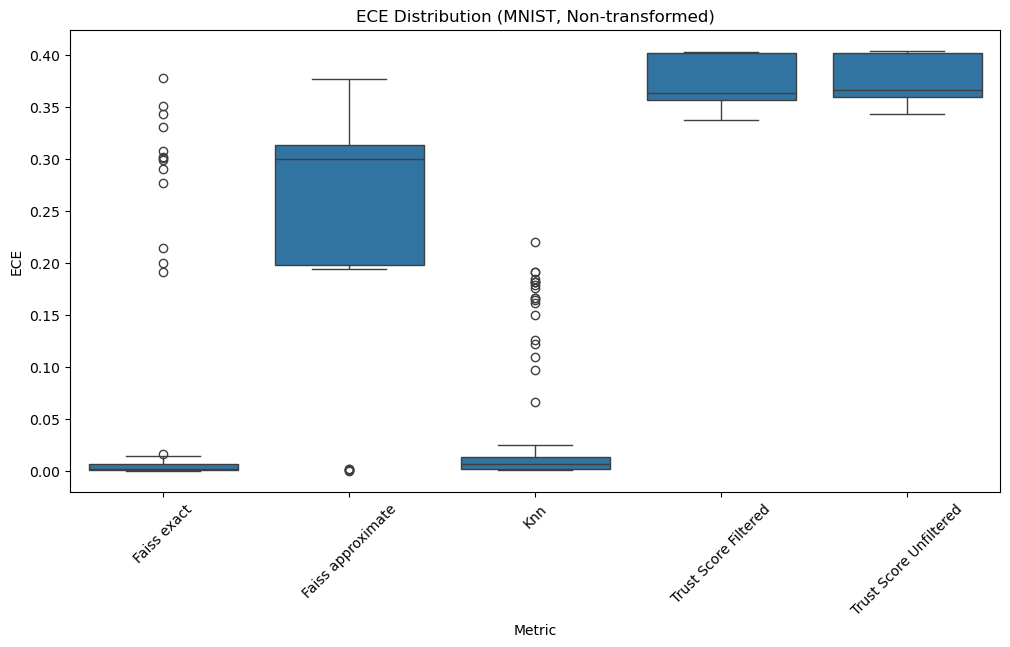

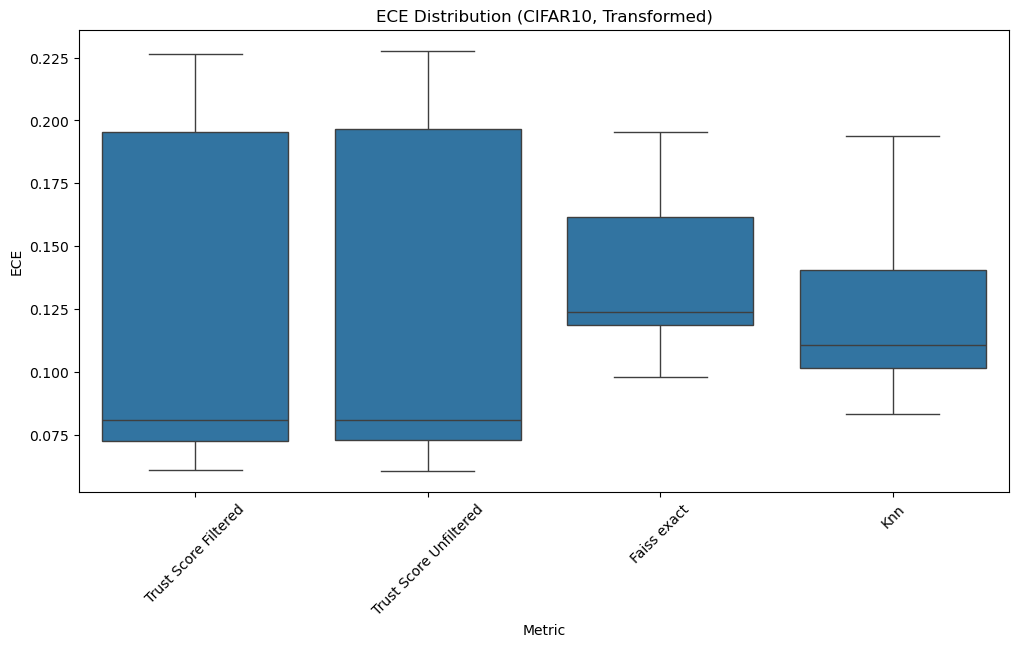

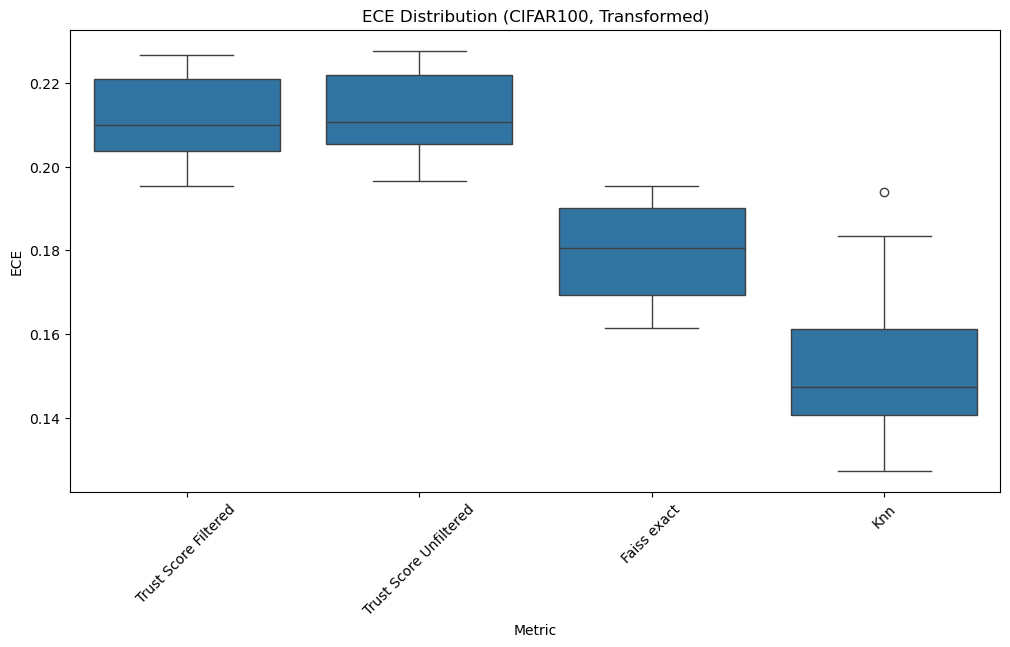

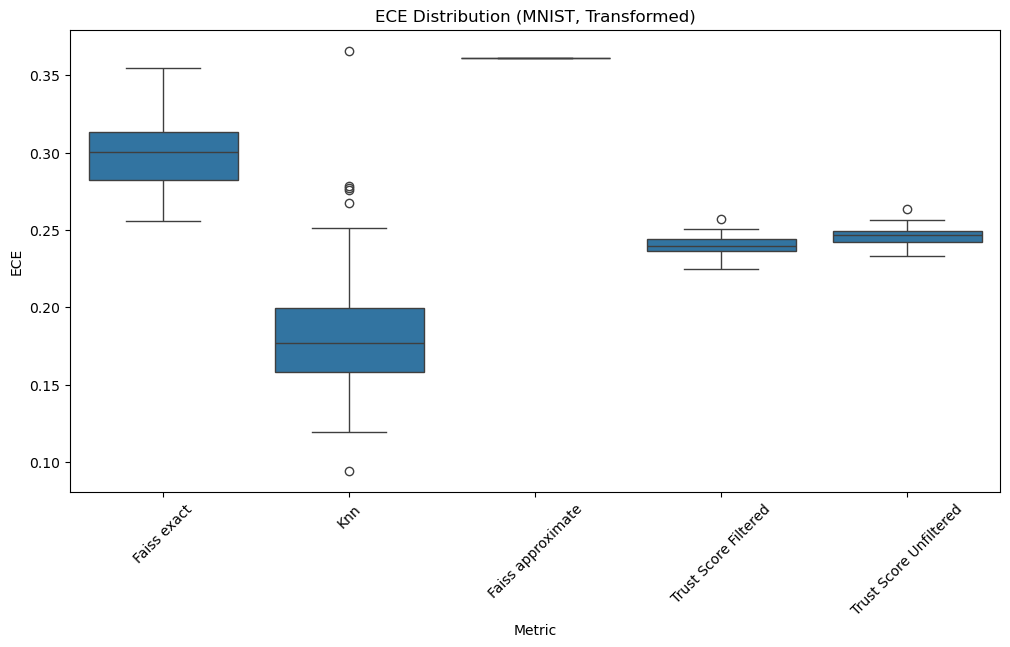

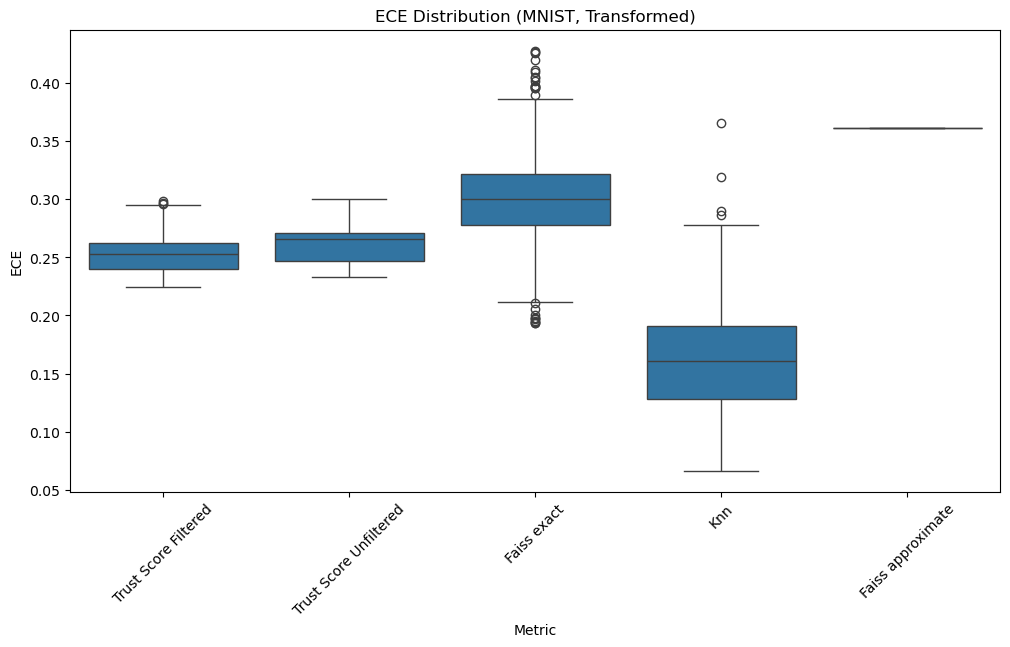

In [50]:
for file_path in file_paths:
    # Extract dataset name and transformation status
    dataset_name = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    transformed = 'non_transformed' not in file_path
    
    # Load and filter data
    filtered_data = filter_data(file_path, methods_to_compare)
    
    # Plot boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Metric', y='ECE', data=filtered_data)
    plt.title(f"ECE Distribution ({dataset_name}, {'Transformed' if transformed else 'Non-transformed'})")
    plt.xticks(rotation=45)
    plt.ylabel('ECE')
    plt.show()
